### 1. Clean Parquet data from Kaggle (integer dtypes parquet)
- This notebook aims to further clean the data taken from Kaggle's user, without affecting data quality

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.feature_engineering_helpers import integerize

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"

In [5]:
RAW_TRAIN_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "train_parquet")
RAW_TRAIN_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "train_pickle")
RAW_TEST_PARQUET_PATH = os.path.join(RAW_DATA_PATH, "test_parquet")
RAW_TEST_PICKLE_PATH = os.path.join(RAW_DATA_PATH, "test_pickle")

In [6]:
%load_ext autoreload
%autoreload

In [7]:
START = time.time()

### Read Data

In [8]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/train.parquet", replace_negative_one=True)
test = read_file(f"{RAW_TEST_PARQUET_PATH}/test.parquet", replace_negative_one=True)

Shape of data: (5531451, 190)
Shape of data: (11363762, 190)
CPU times: user 52.9 s, sys: 1min 14s, total: 2min 7s
Wall time: 1min 19s


In [9]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 6.8 s, sys: 11.5 s, total: 18.3 s
Wall time: 23.4 s


In [10]:
train_cid_list = train["customer_ID"].unique().tolist()

In [11]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


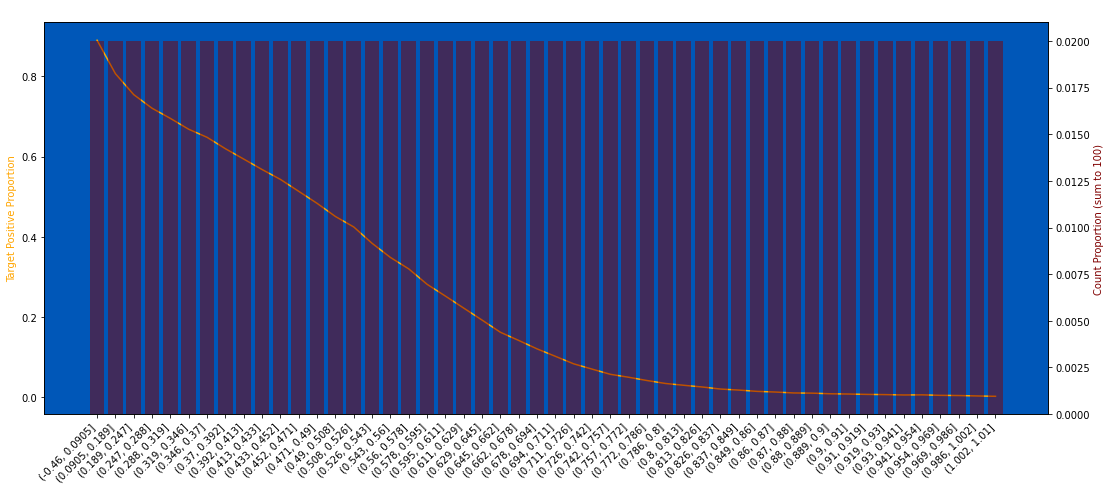

In [12]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [13]:
train["P_2"] = train["P_2"].round(2)
test["P_2"] = test["P_2"].round(2)

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


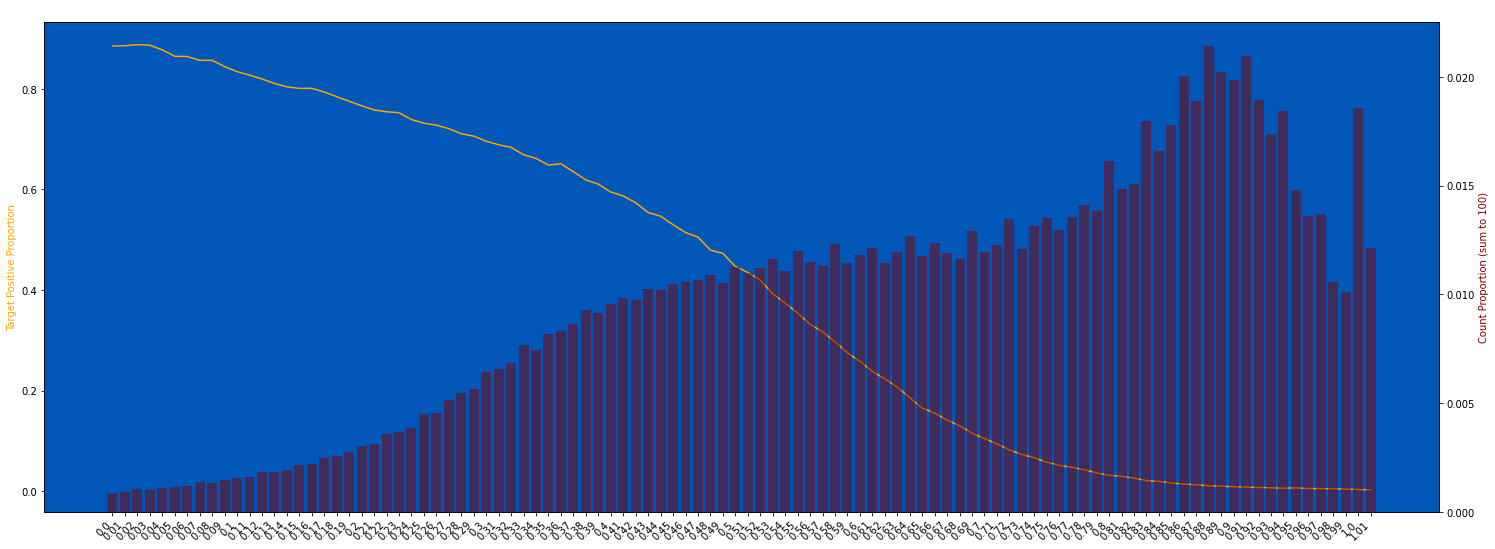

In [14]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


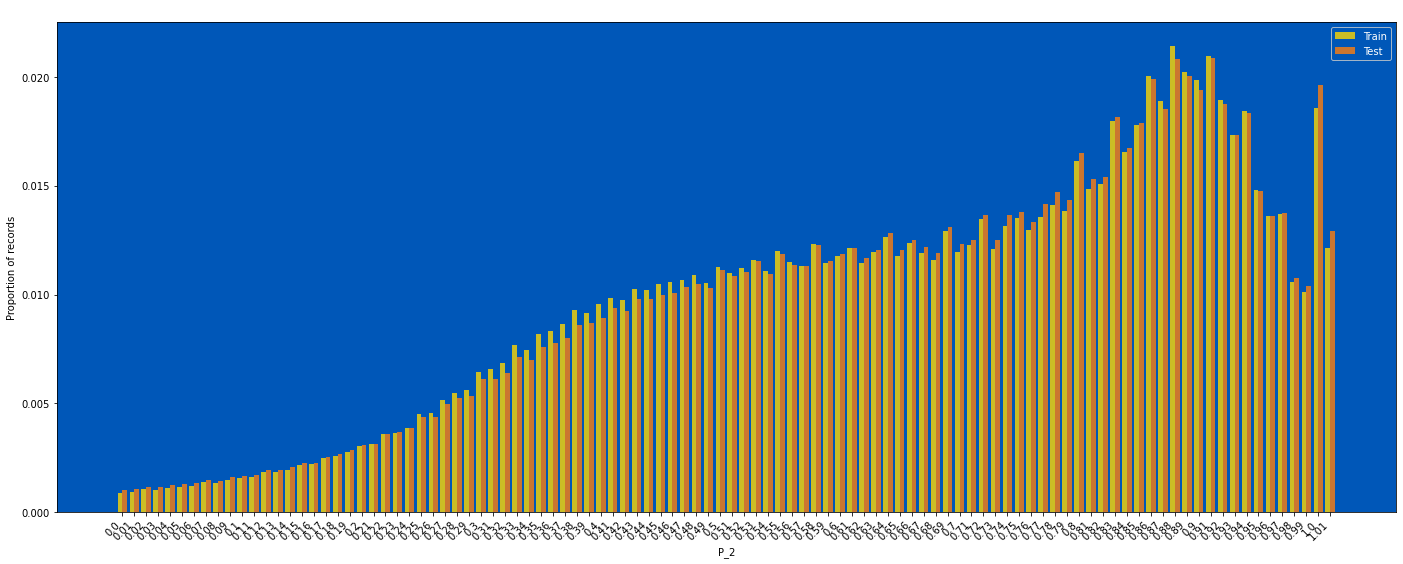

In [15]:
plot_train_test_distribution(train, test, "P_2", nunique_thr=150, figsize=(24, 10))

In [16]:
# plot_sampled_time_series(train, labels, "S_3", 50)

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


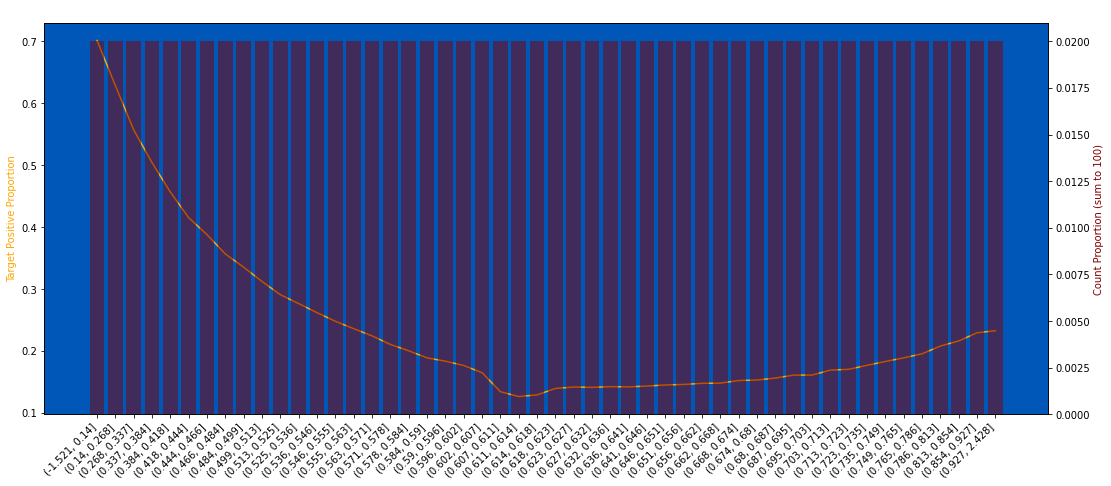

In [17]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [18]:
train["P_3"] = train["P_3"].round(2)
test["P_3"] = test["P_3"].round(2)

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


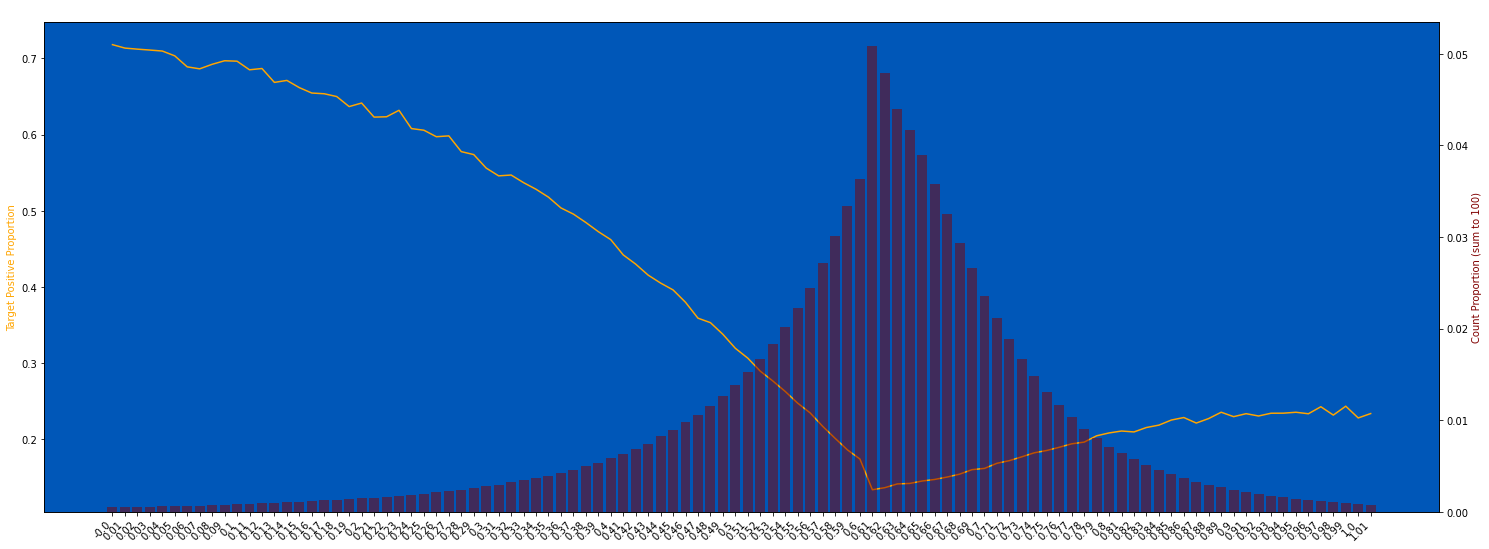

In [19]:
p3_summary = plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10), 
                               drop_outlier=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


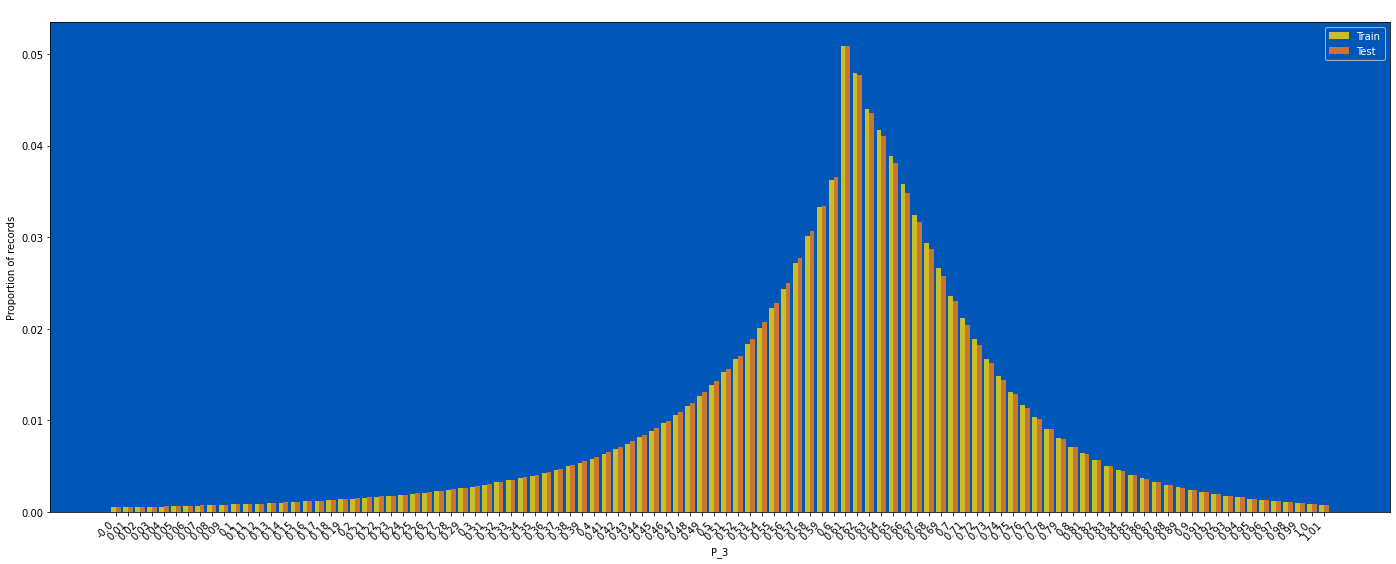

In [20]:
plot_train_test_distribution(train, test, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


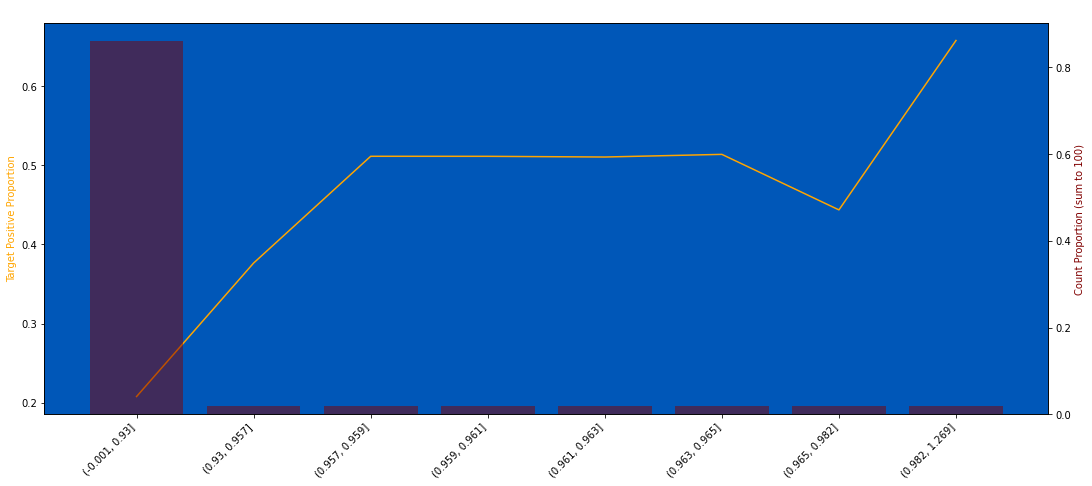

In [21]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [22]:
train["P_4"] = train["P_4"].round(2)
test["P_4"] = test["P_4"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


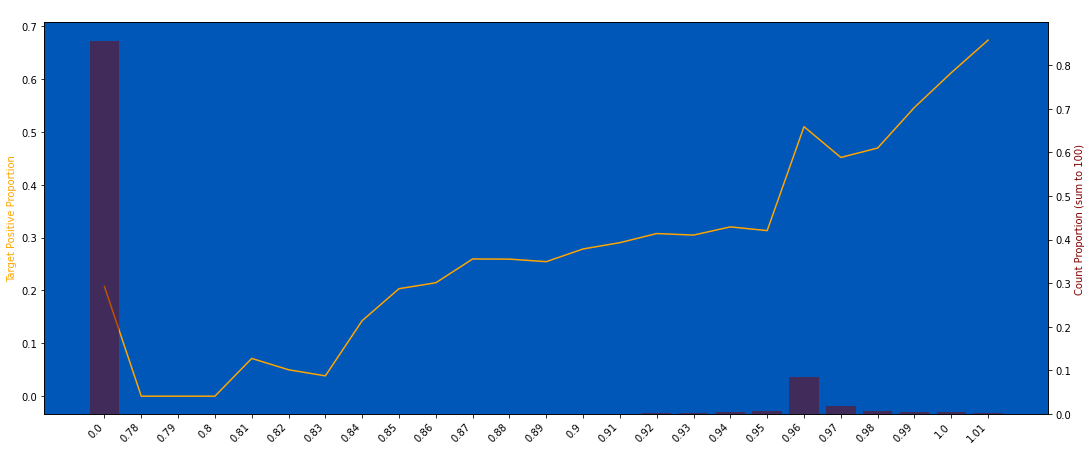

In [23]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

In [24]:
train["P_4"] = train["P_4"].replace(0, np.nan)
test["P_4"] = test["P_4"].replace(0, np.nan)

4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


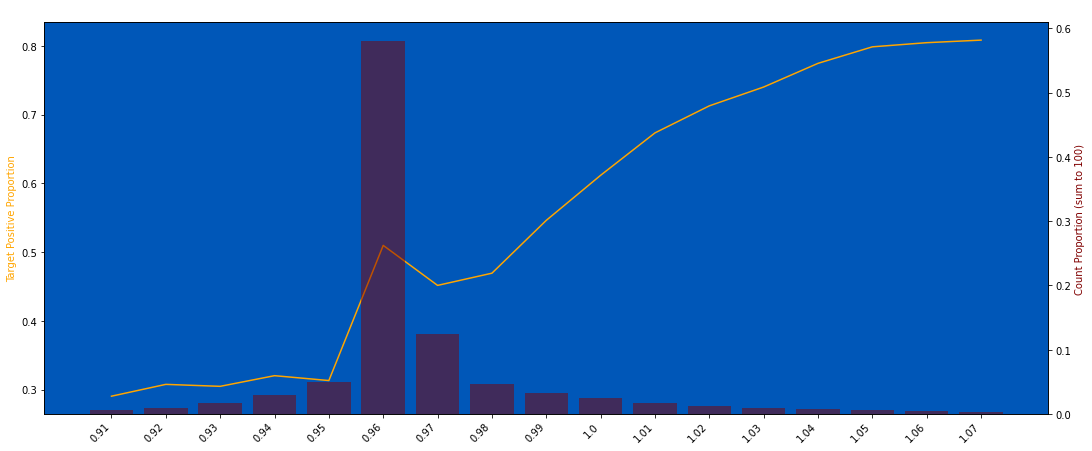

In [25]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


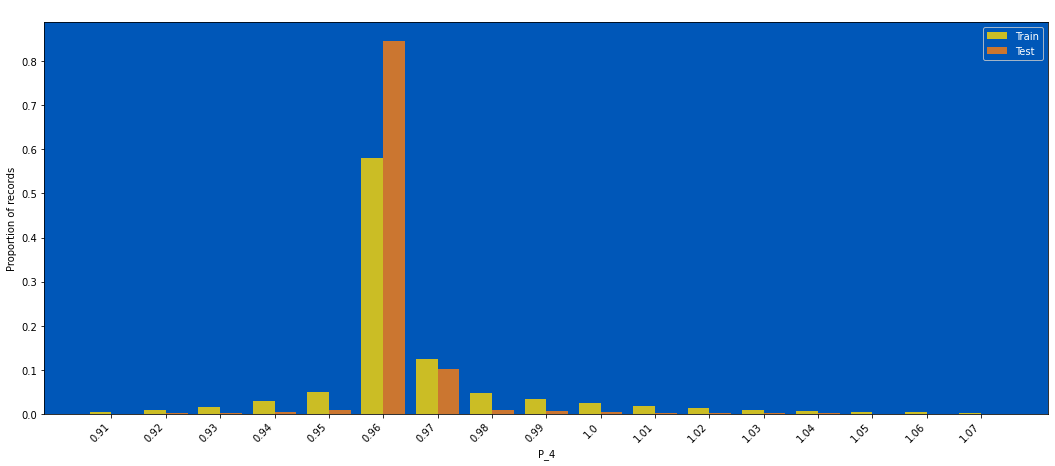

In [26]:
plot_train_test_distribution(train, test, "P_4")

**Train Test Skew: Slight**

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


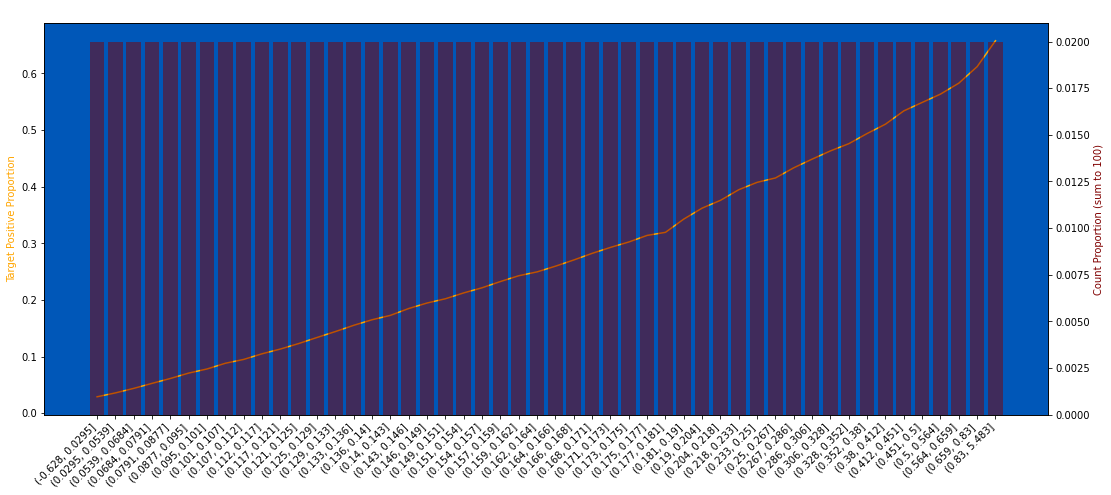

In [27]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [28]:
train["S_3"] = train["S_3"].round(2)
test["S_3"] = test["S_3"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


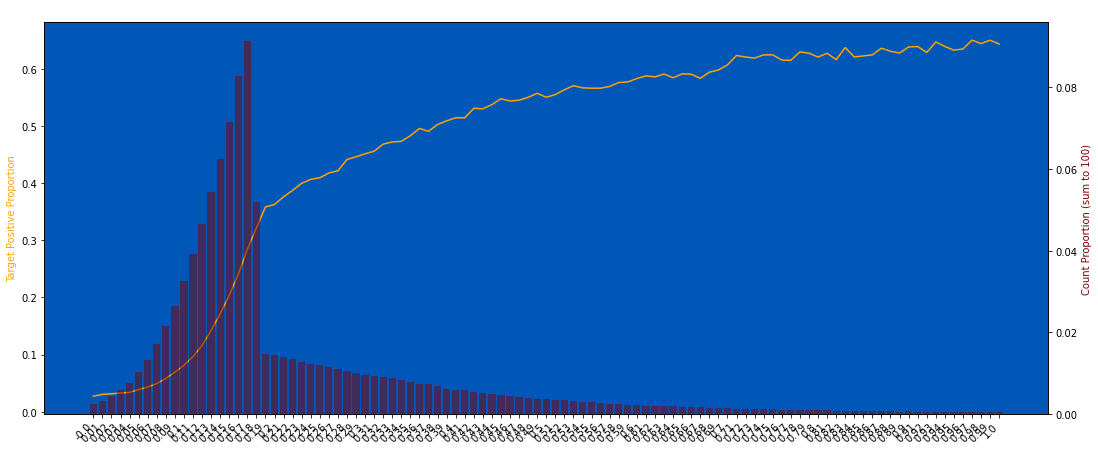

In [29]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=400, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


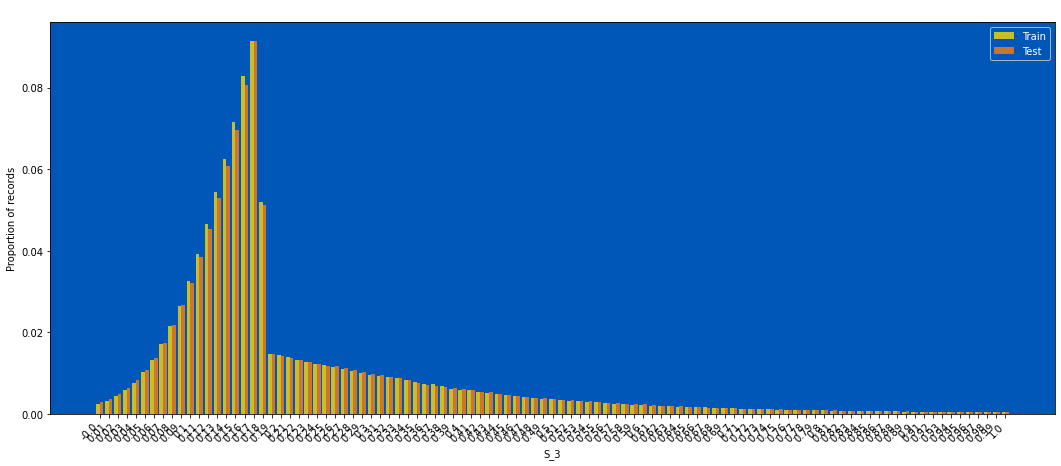

In [30]:
plot_train_test_distribution(train, test, "S_3", nunique_thr=500)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


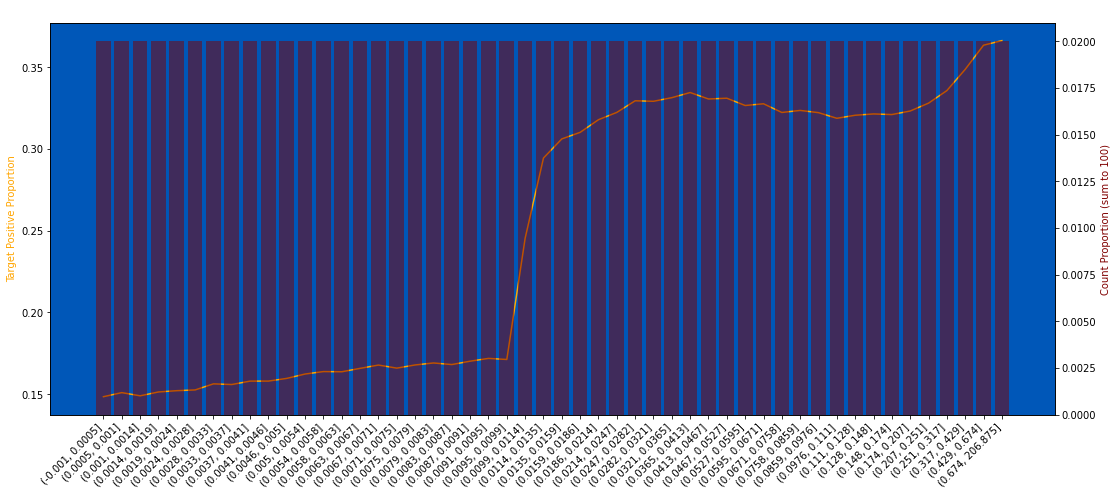

In [31]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [32]:
train["S_5"] = train["S_5"].round(2)
test["S_5"] = test["S_5"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


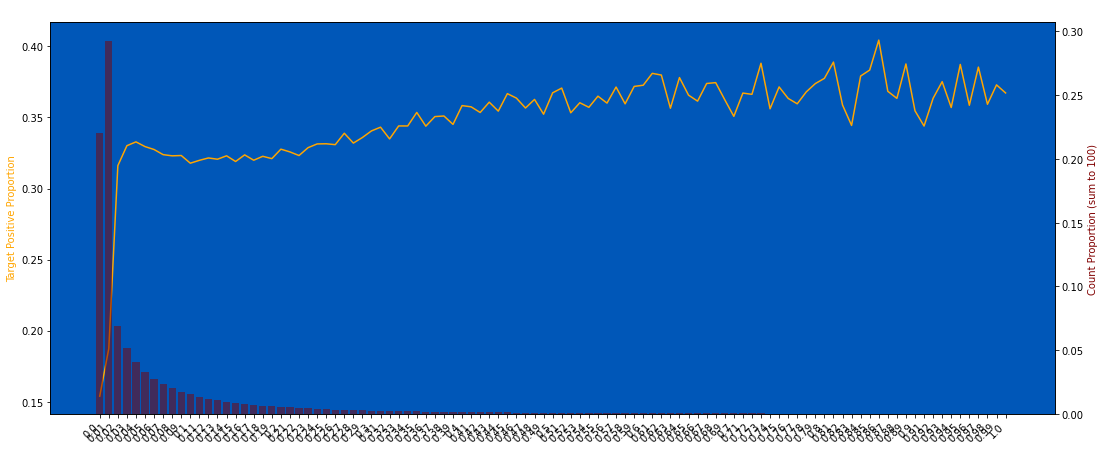

In [33]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


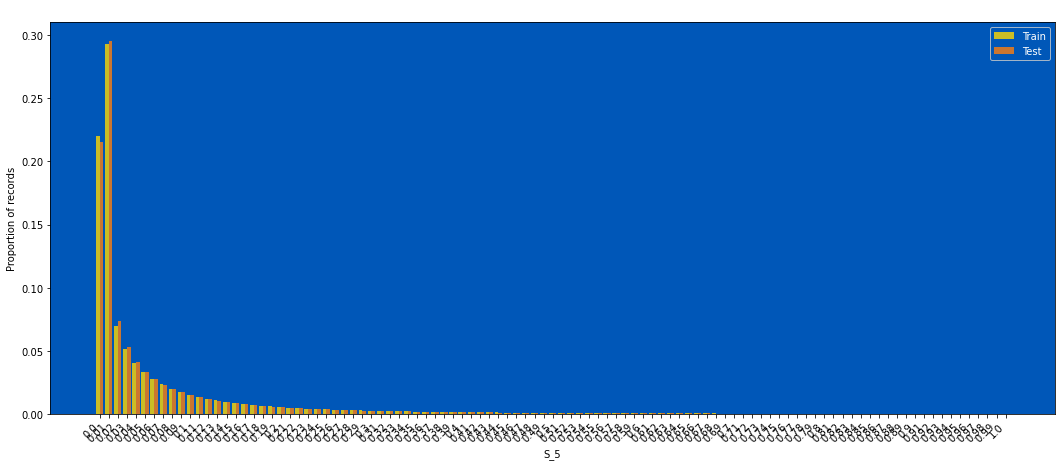

In [34]:
plot_train_test_distribution(train, test, "S_5", nunique_thr=5000)

In [35]:
# a = train.groupby("customer_ID")["S_5"].max() - train.groupby("customer_ID")["S_5"].min()
# b = train.groupby("customer_ID")["S_5"].min()
# c = pd.concat([a, b], axis=1)
# c.columns = ["range", "min"]
# c.loc[(c["range"] > 0) & (c["min"] <= 0.01)]

In [36]:
# train.loc[train["customer_ID"] == "0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a", "S_5"].replace((0, 0.01), np.nan)

### S_6

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


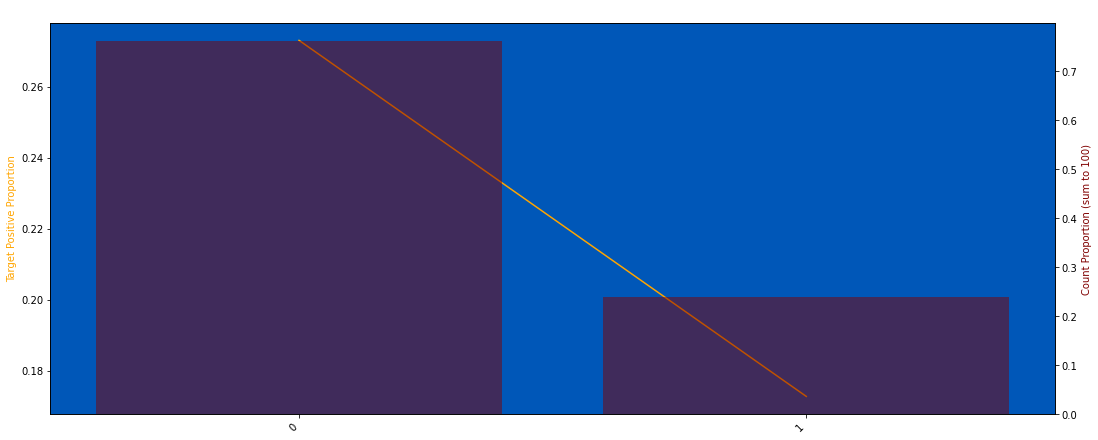

In [37]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


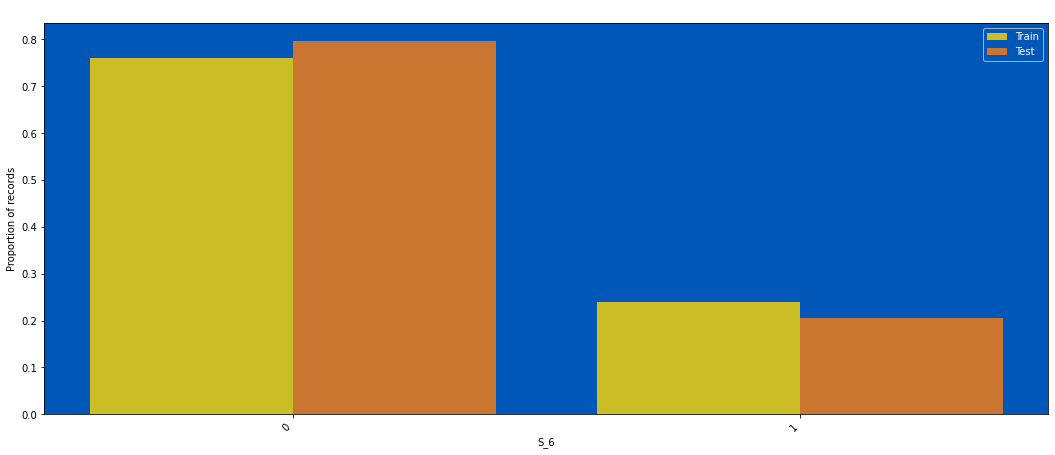

In [38]:
plot_train_test_distribution(train, test, "S_6", nunique_thr=5000)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


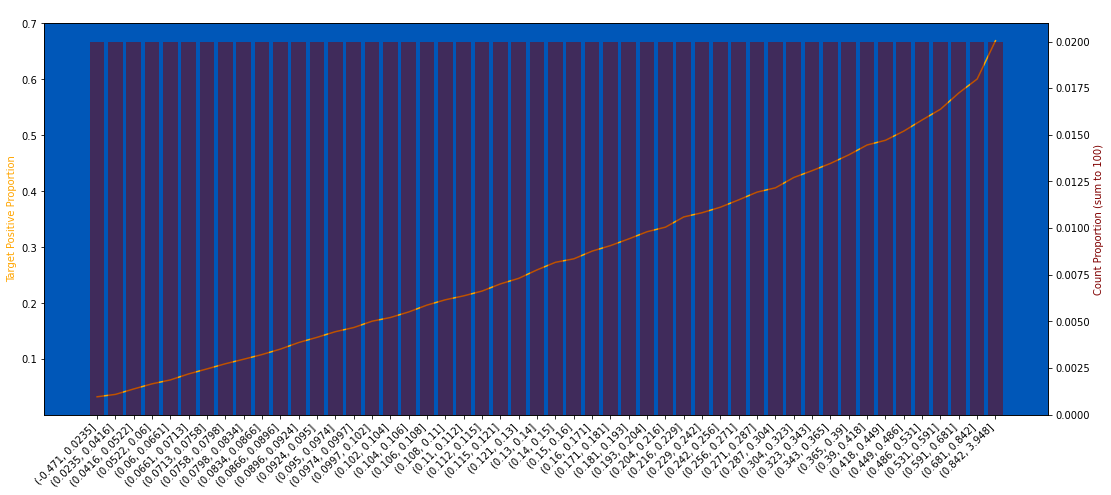

In [39]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [40]:
train["S_7"] = train["S_7"].round(2)
test["S_7"] = test["S_7"].round(2)

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


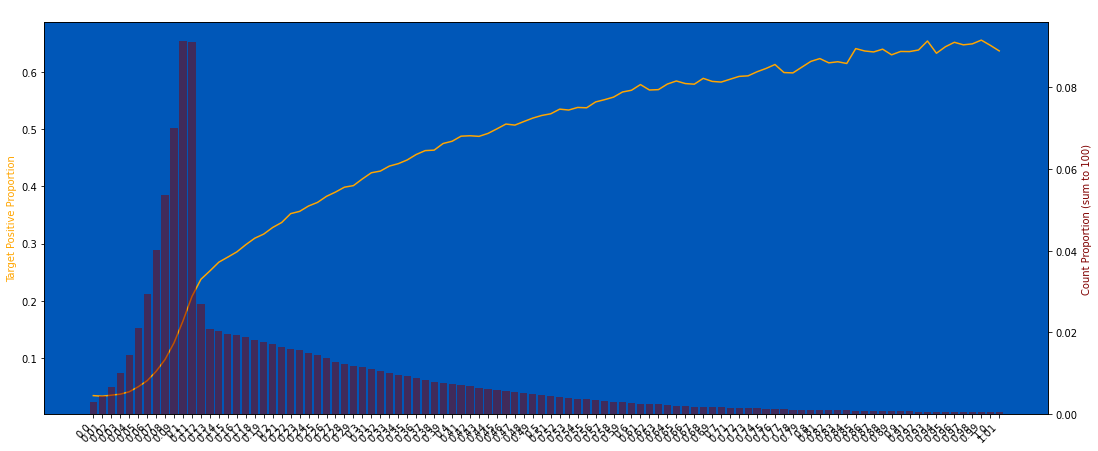

In [41]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


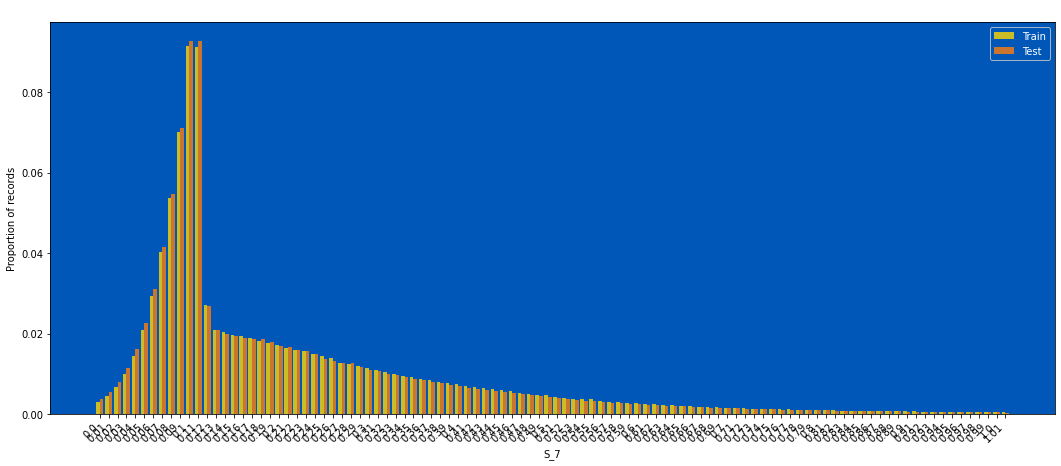

In [42]:
plot_train_test_distribution(train, test, "S_7", nunique_thr=5000)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


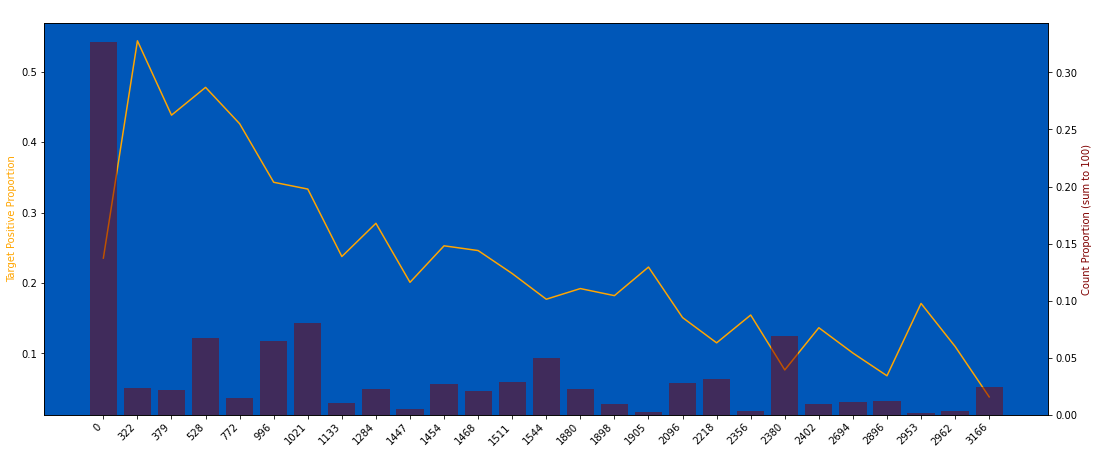

In [43]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


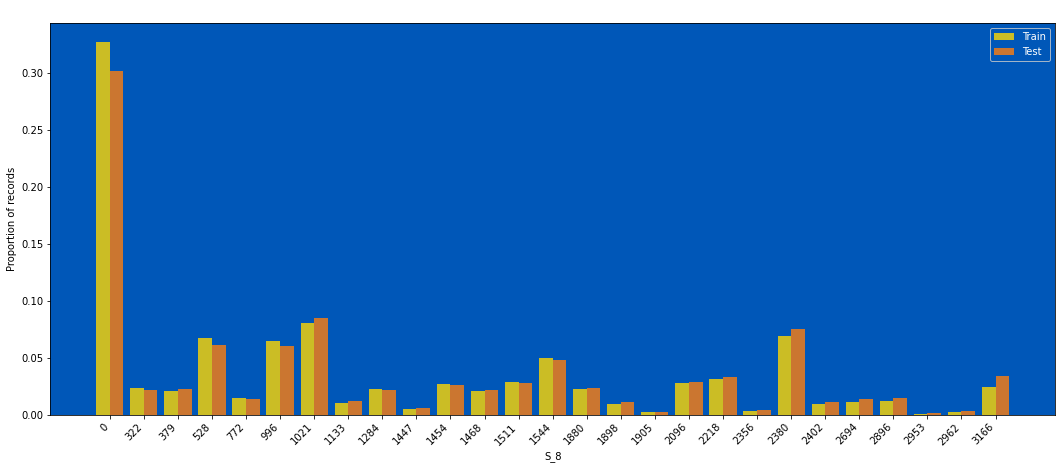

In [44]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=500)

In [45]:
s8_mapping_dict = dict(zip(sorted(train["S_8"].unique()), range(train["S_8"].nunique())))

In [46]:
train["S_8"] = train["S_8"].map(s8_mapping_dict).replace(0, np.nan)
test["S_8"] = test["S_8"].map(s8_mapping_dict).replace(0, np.nan)

1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


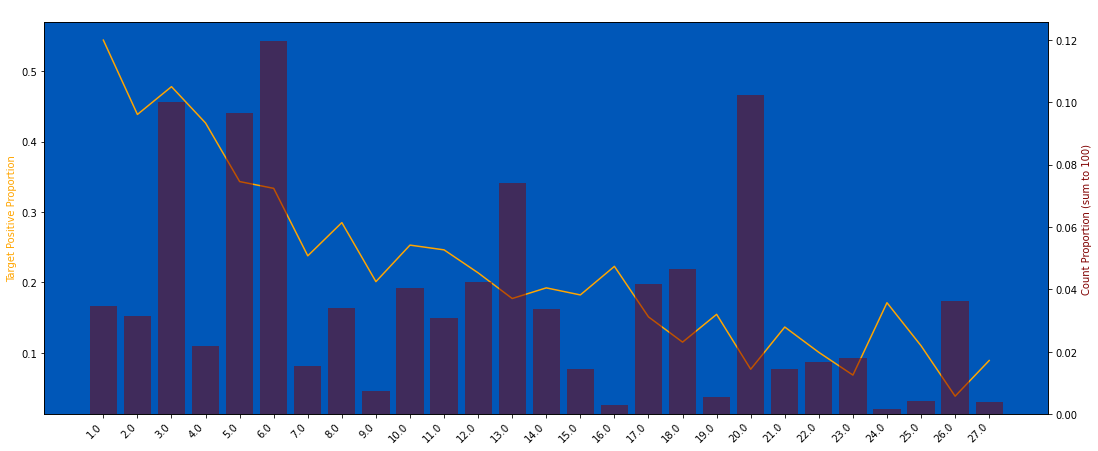

In [47]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


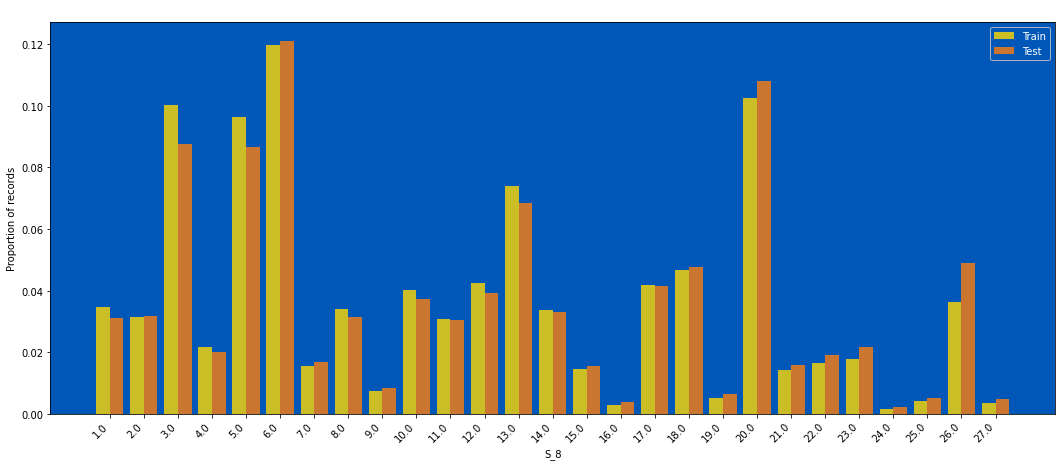

In [48]:
plot_train_test_distribution(train, test, "S_8", nunique_thr=100)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


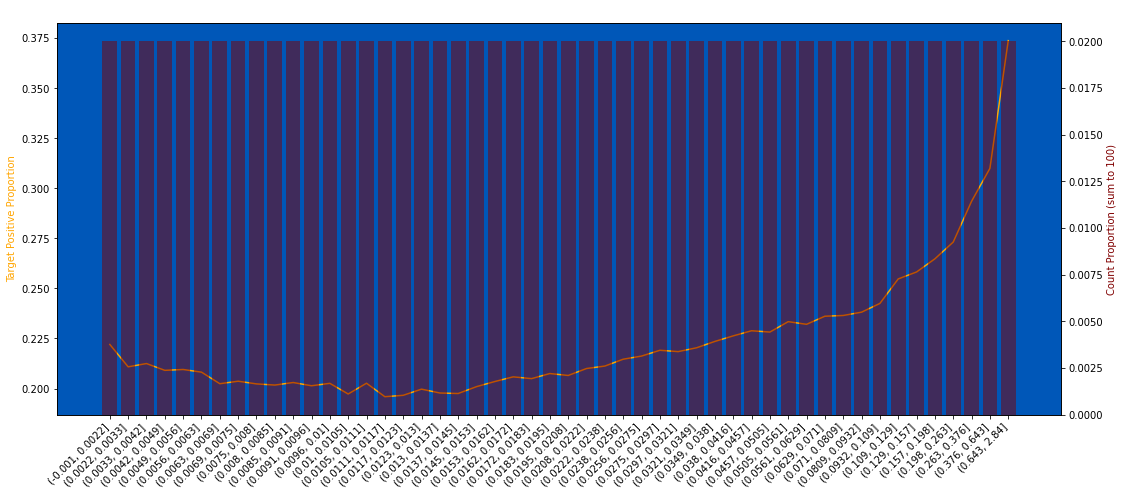

In [49]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [50]:
train["S_9"] = train["S_9"].round(2)
test["S_9"] = test["S_9"].round(2)

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


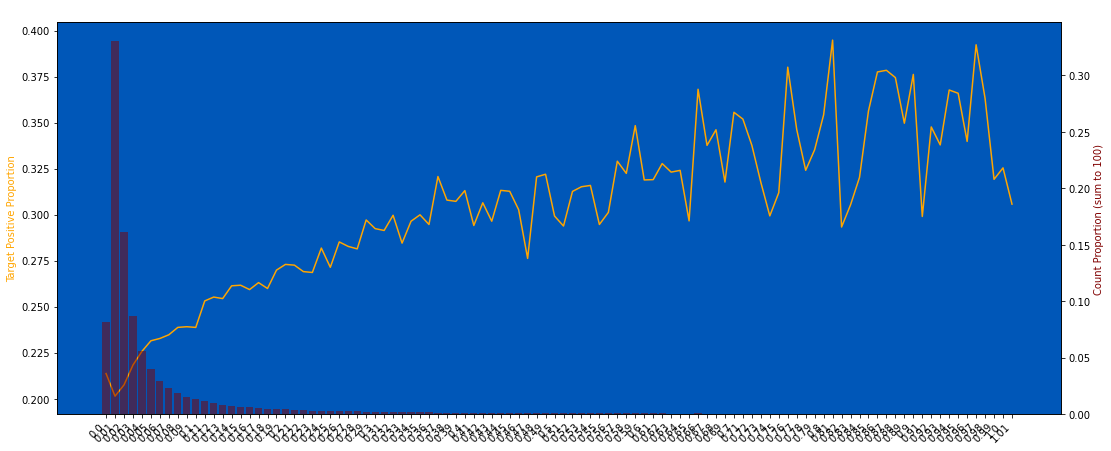

In [51]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


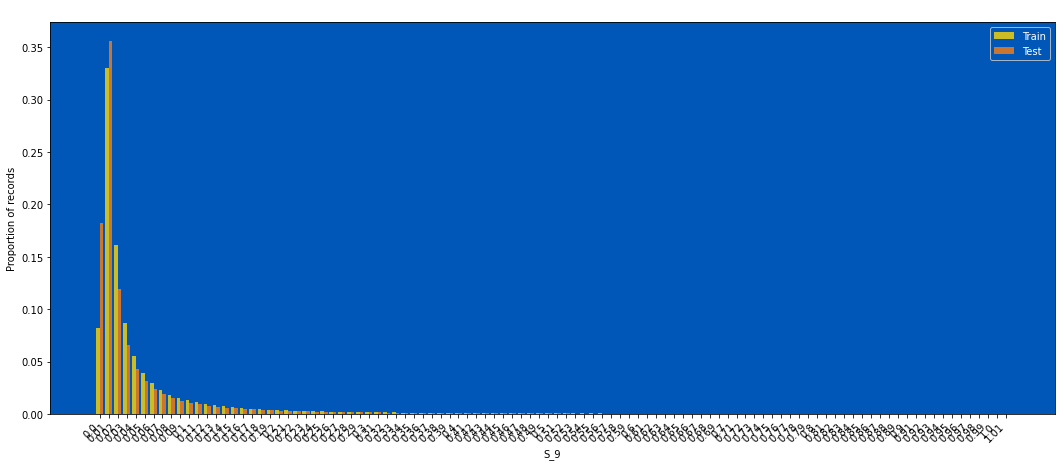

In [52]:
plot_train_test_distribution(train, test, "S_9", nunique_thr=300)

**Train Test Skew: Slight**

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


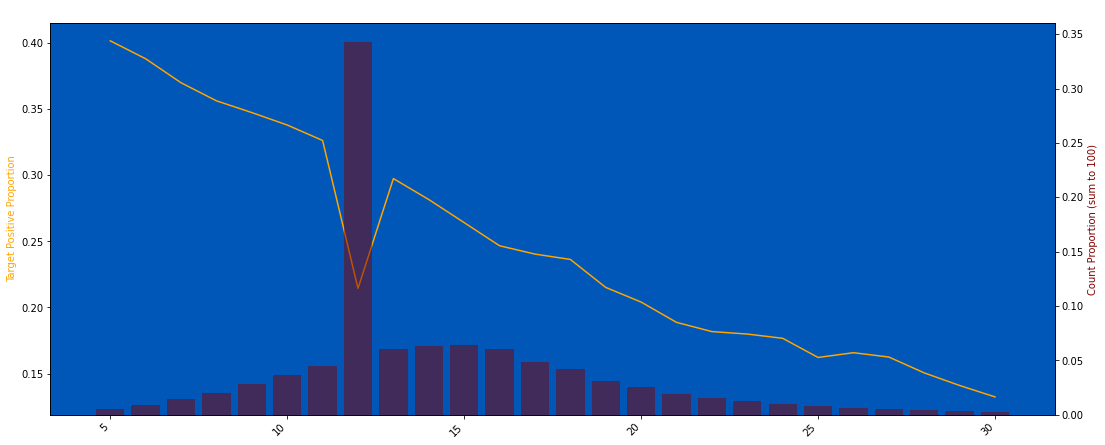

In [53]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

**Check: Identify if there is some 12 originated from the raw data is actually a missing value / NaN**

Bottom 1% and Top 1% are dropped from this chart


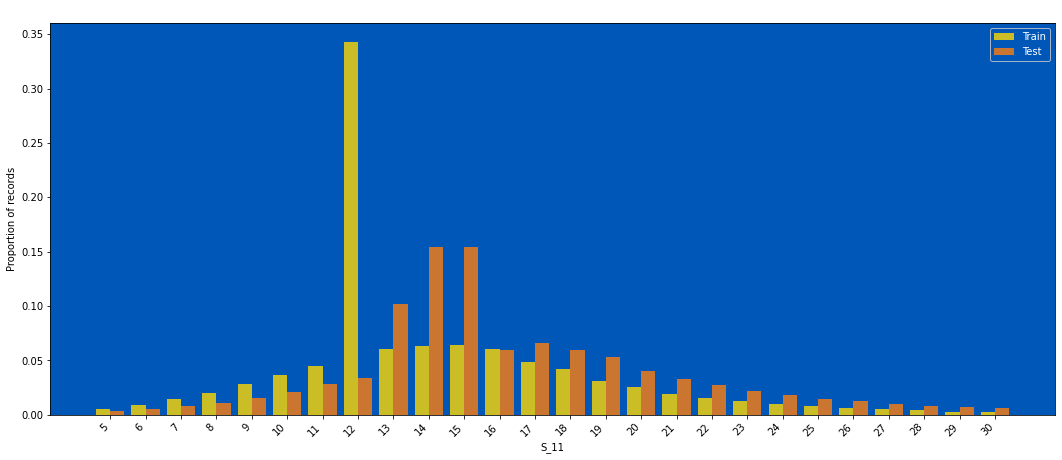

In [54]:
plot_train_test_distribution(train, test, "S_11", nunique_thr=500)

**Train Test Skew: Heavy**

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


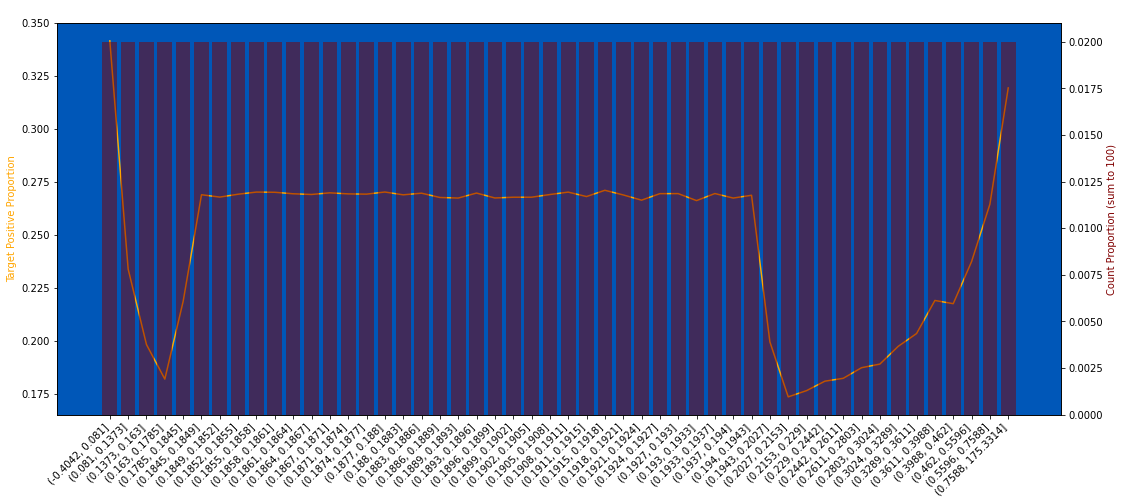

In [55]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

0 null count, 0.000 null proportion
nan of the targets have label = 1


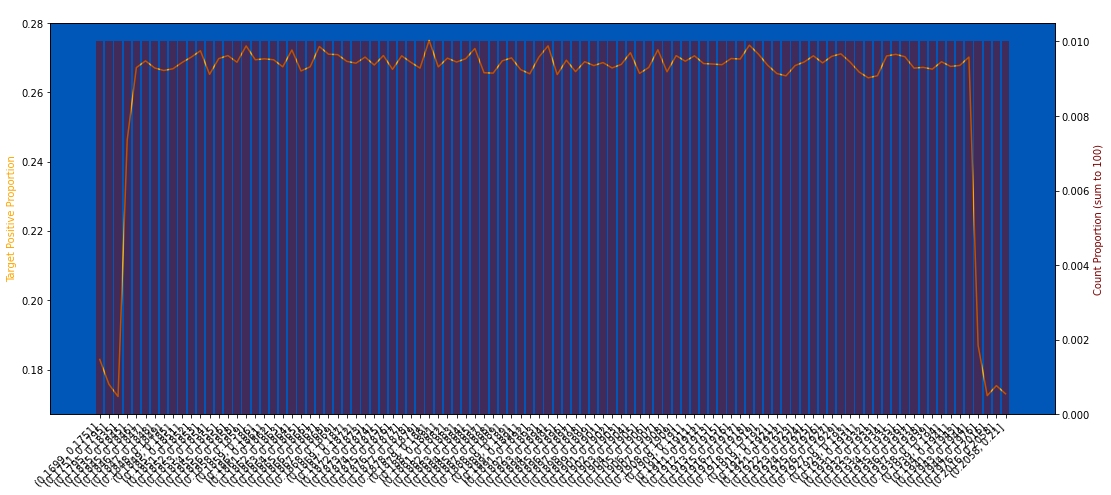

In [56]:
temp = train.loc[train["S_12"].between(0.17, 0.21)]
plot_target_check(temp, "S_12", q=100, use_raw_bin=True)

In [57]:
train.loc[train["S_12"].between(0.1835, 0.1945), "S_12"] = np.nan
test.loc[test["S_12"].between(0.1835, 0.1945), "S_12"] = np.nan

In [58]:
train["S_12"] = train["S_12"].round(2)
test["S_12"] = test["S_12"].round(2)

3527080 null count, 0.638 null proportion
0.2685 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


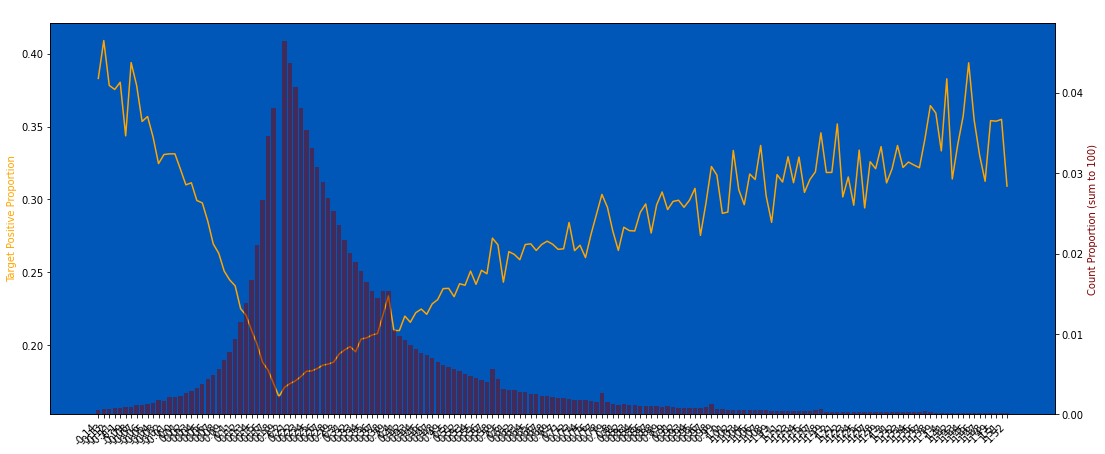

In [59]:
s12_summary = plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, return_df=True)

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


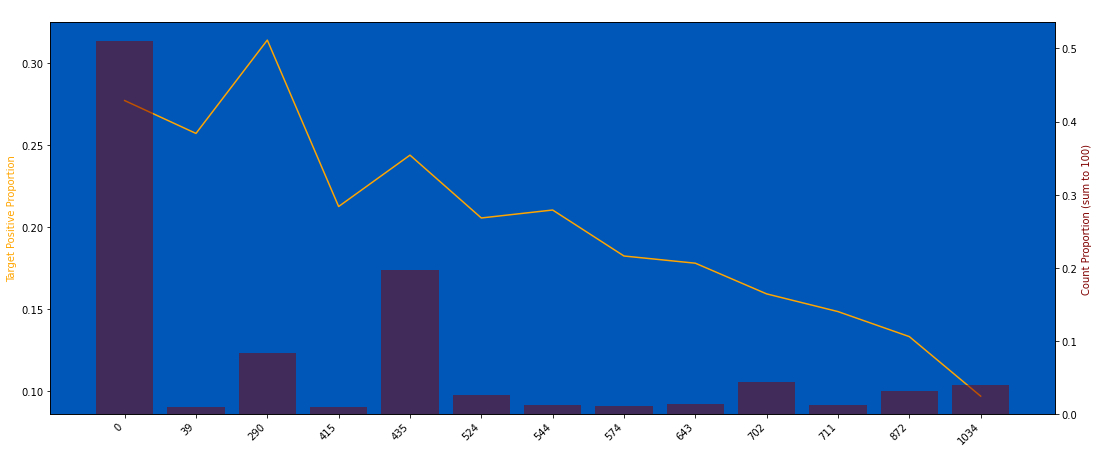

In [60]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


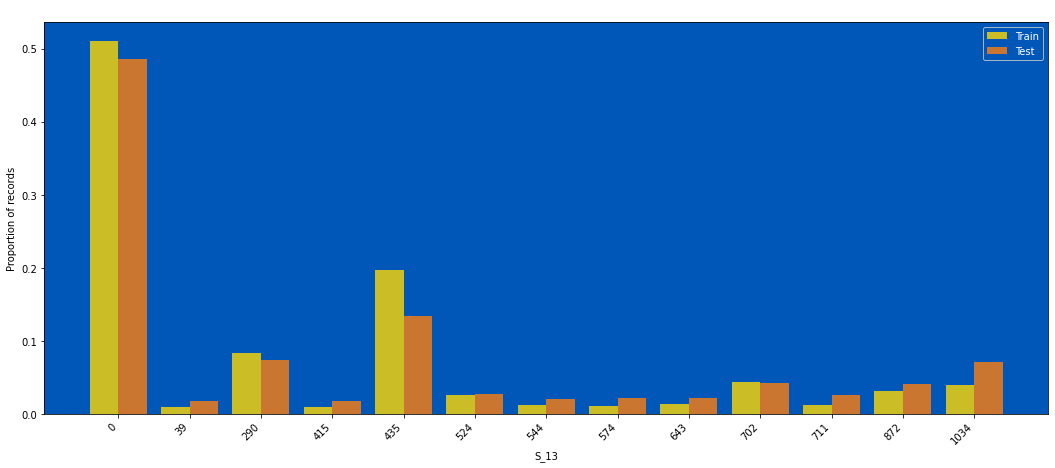

In [61]:
plot_train_test_distribution(train, test, "S_13", nunique_thr=500)

In [62]:
s13_mapping_dict = dict(zip(sorted(train["S_13"].unique()), range(train["S_13"].nunique())))

In [63]:
train["S_13"] = train["S_13"].map(s13_mapping_dict)
test["S_13"] = test["S_13"].map(s13_mapping_dict)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


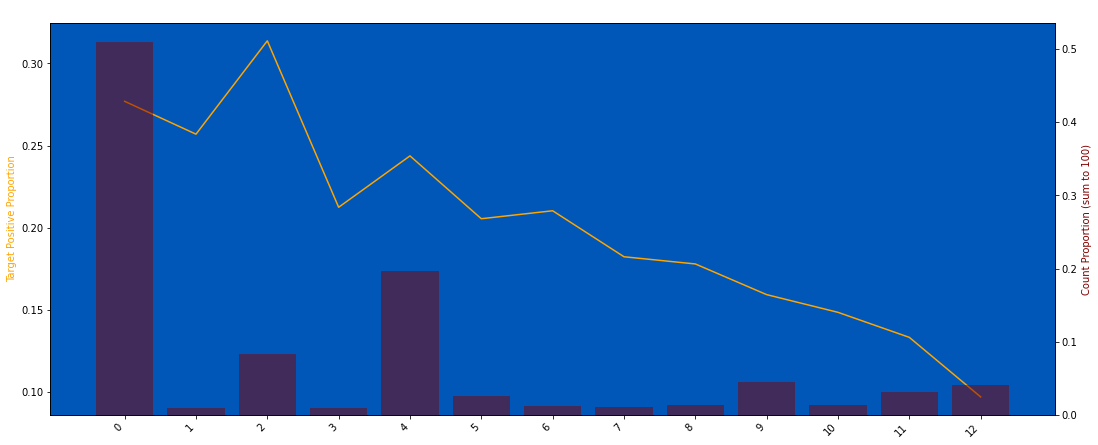

In [64]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


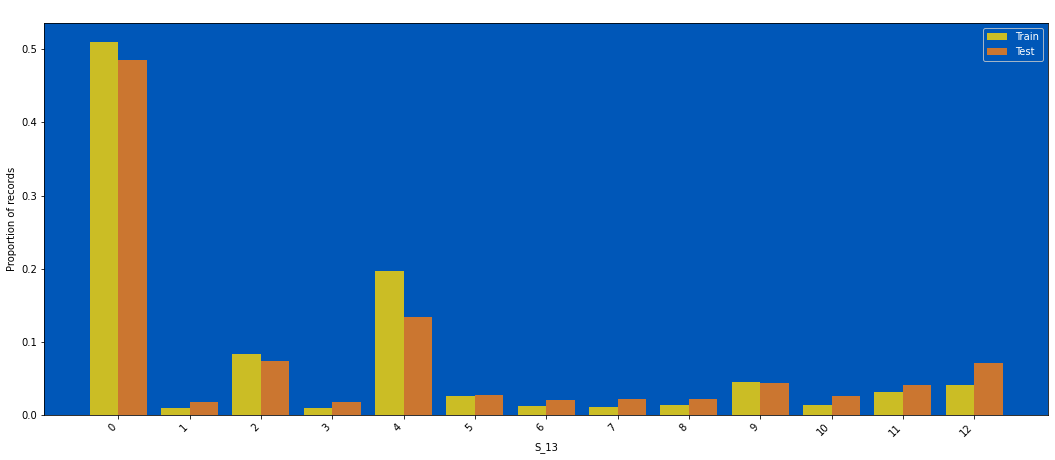

In [65]:
plot_train_test_distribution(train, test, "S_13", nunique_thr=500)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


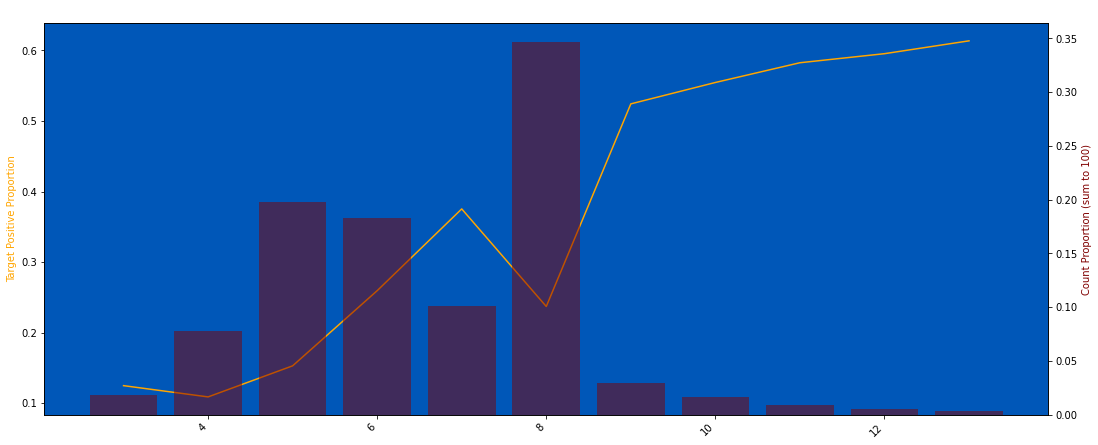

In [66]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

**Check: Identify if there is some 8 originated from the raw data is actually a missing value / NaN**

Bottom 1% and Top 1% are dropped from this chart


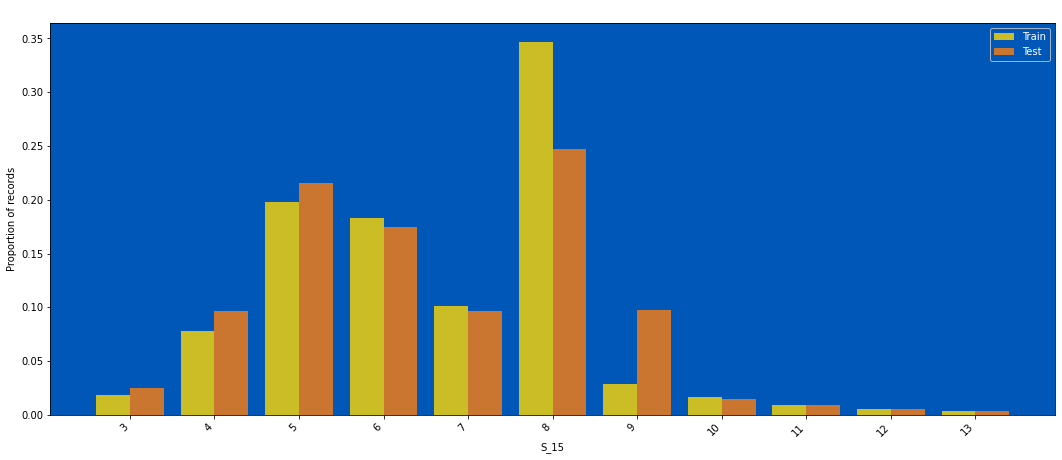

In [67]:
plot_train_test_distribution(train, test, "S_15", nunique_thr=500)

**Train Test Skew: Moderate**

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


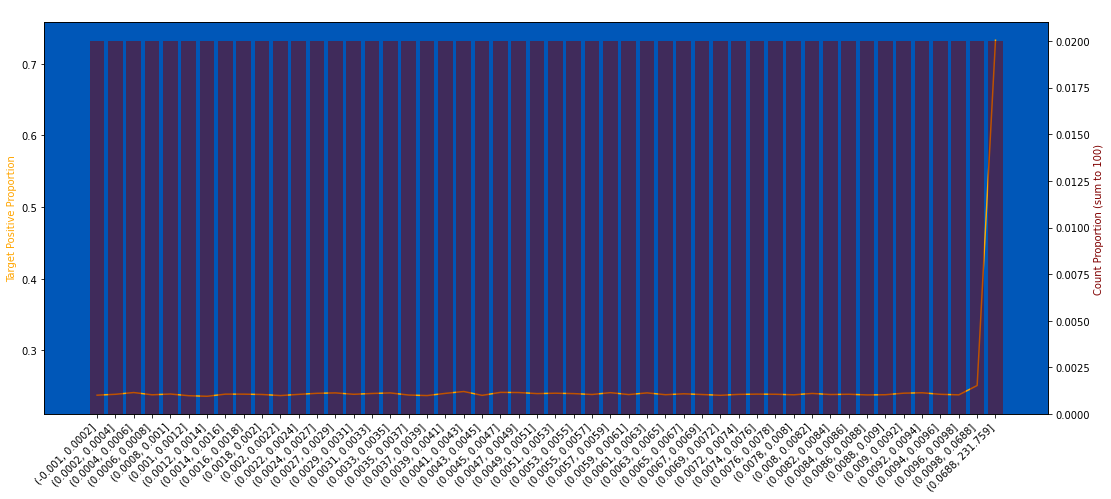

In [68]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [69]:
train["S_16"] = train["S_16"].round(2).replace(0, 0.01)
test["S_16"] = test["S_16"].round(2).replace(0, 0.01)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


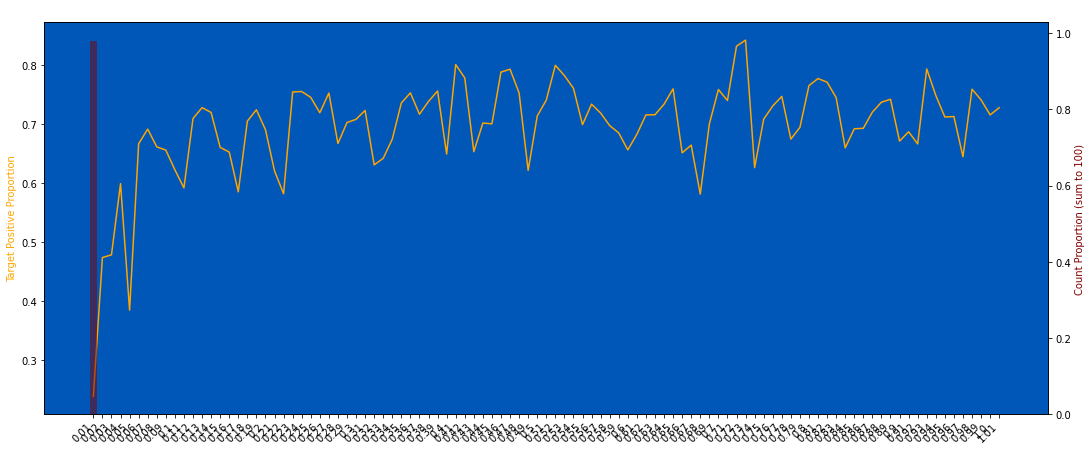

In [70]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


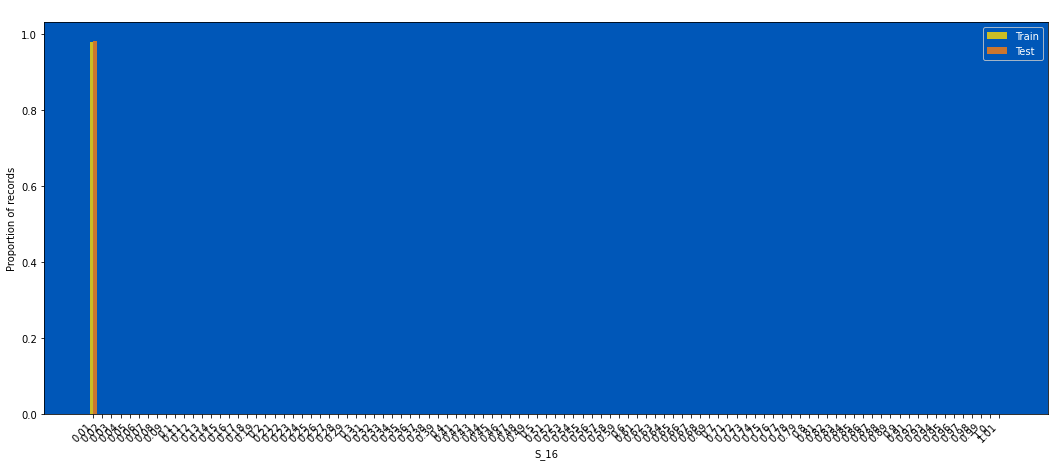

In [71]:
plot_train_test_distribution(train, test, "S_16", nunique_thr=15000)

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


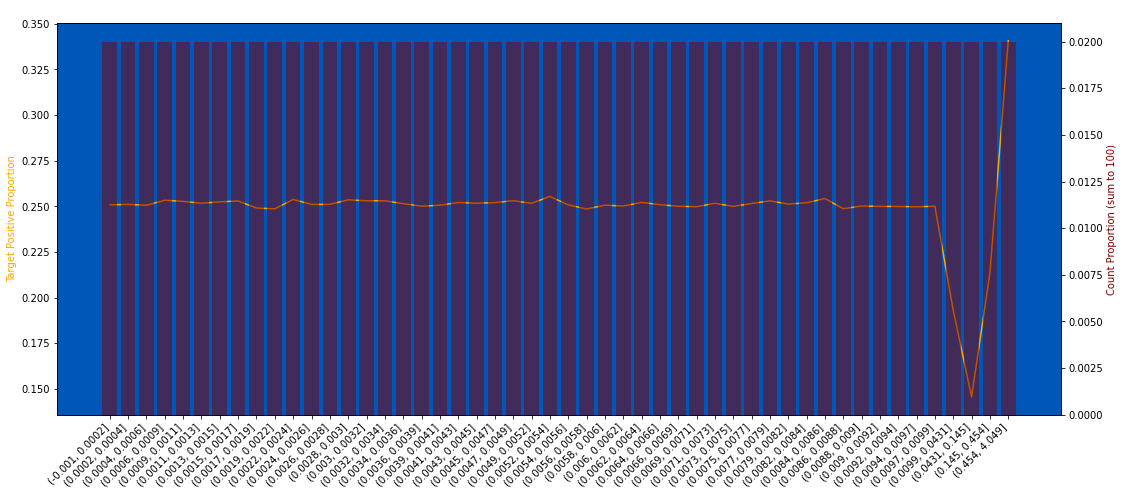

In [72]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [73]:
train["S_17"] = train["S_17"].round(2)
test["S_17"] = test["S_17"].round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


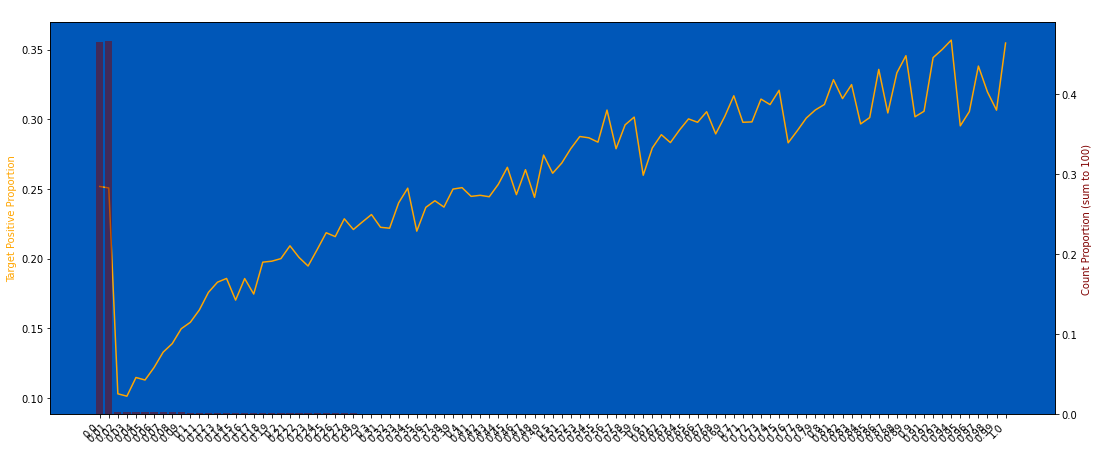

In [74]:
s17_summary = plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True, return_df=True)

In [75]:
train["S_17"] = train["S_17"].replace(0.01, 0)
test["S_17"] = test["S_17"].replace(0.01, 0)

In [76]:
train["S_17"] = train["S_17"].replace(0, np.nan)
test["S_17"] = test["S_17"].replace(0, np.nan)

5159577 null count, 0.933 null proportion
0.2512 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


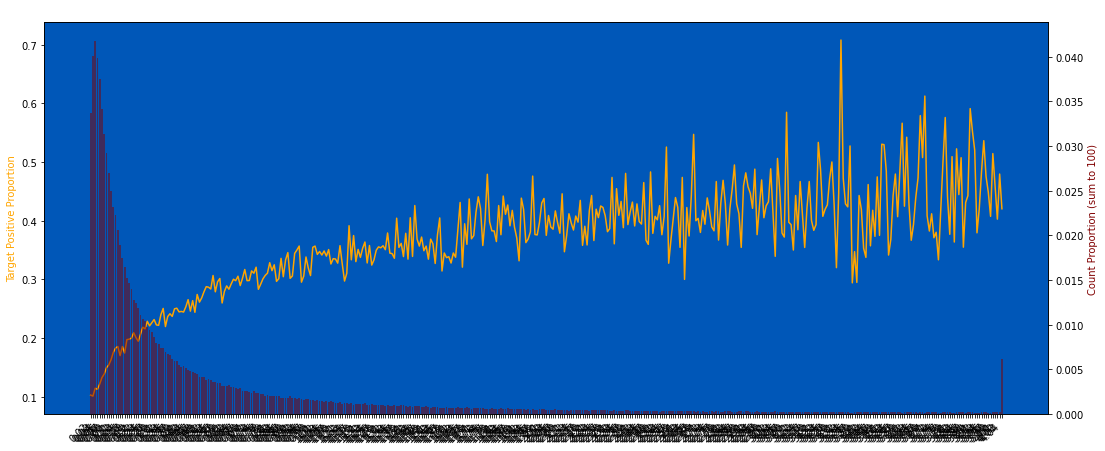

In [77]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=15000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


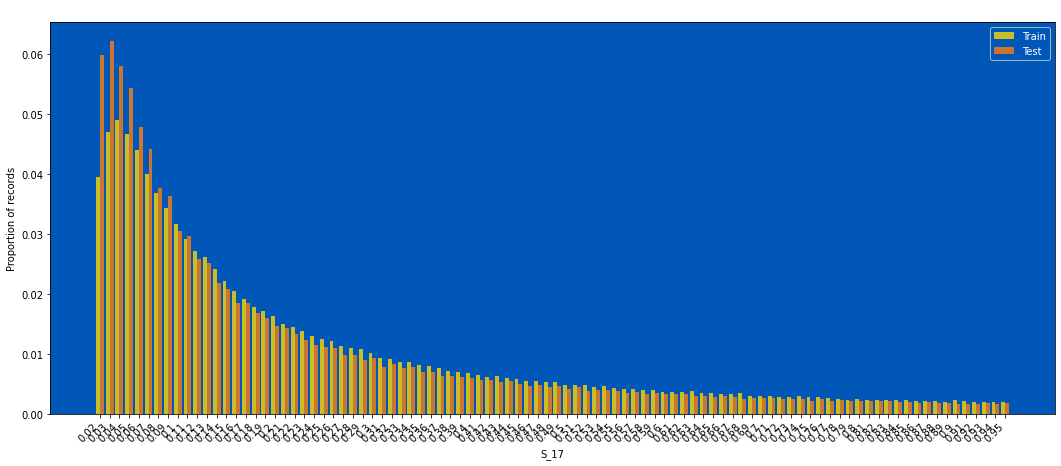

In [78]:
plot_train_test_distribution(
    train.loc[train["S_17"] <= 1], 
    test.loc[test["S_17"] <= 1], 
    "S_17", 
    nunique_thr=15000
)

**Train Test Skew: Heavy**

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


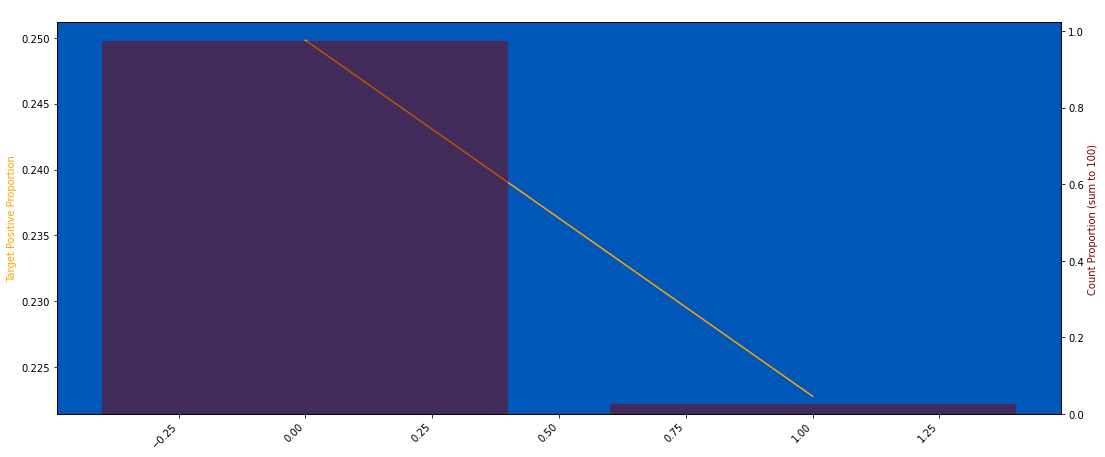

In [79]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

Bottom 1% and Top 1% are dropped from this chart


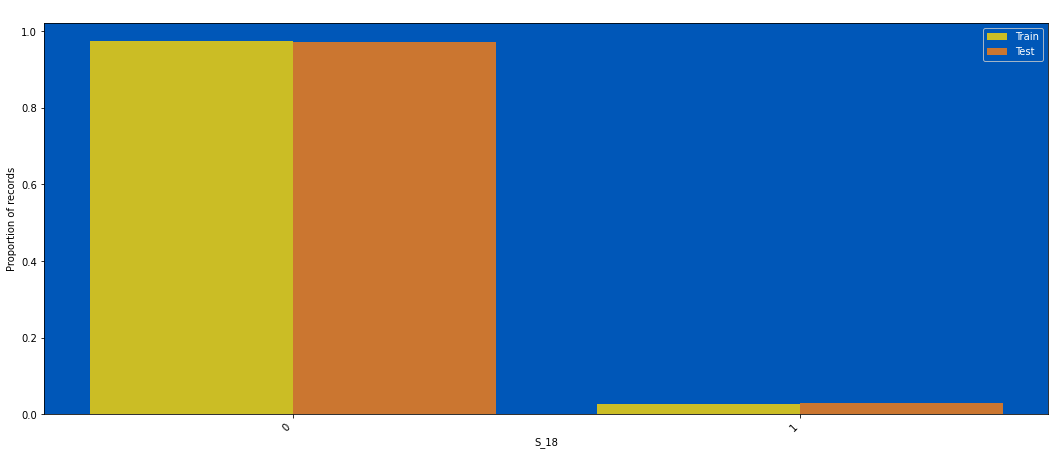

In [80]:
plot_train_test_distribution(train, test, "S_18", nunique_thr=150)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


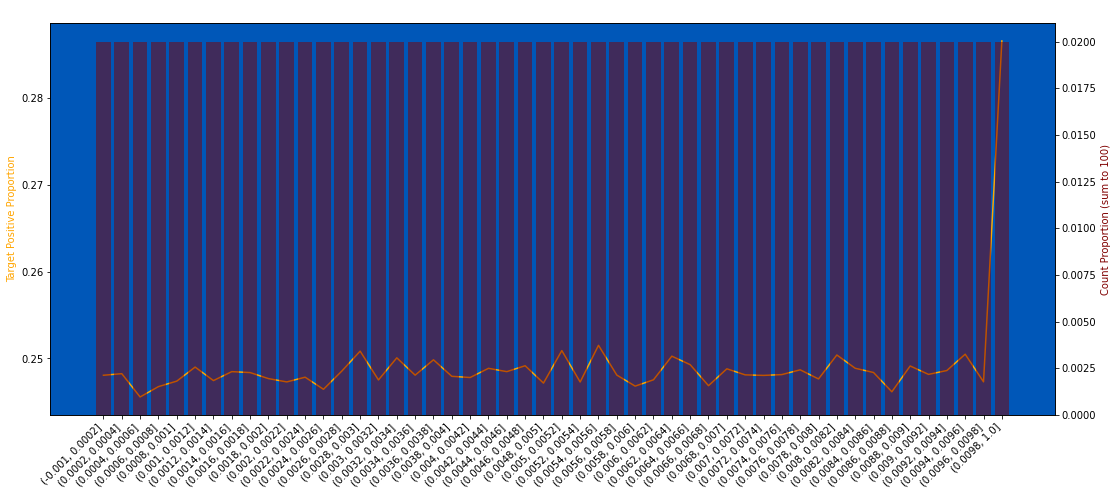

In [81]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [82]:
train["S_19"] = train["S_19"].round(2)
test["S_19"] = test["S_19"].round(2)

In [83]:
train["S_19"] = train["S_19"].replace((0, 0.01), np.nan)
test["S_19"] = test["S_19"].replace((0, 0.01), np.nan)

5526372 null count, 0.999 null proportion
0.2487 of the targets have label = 1


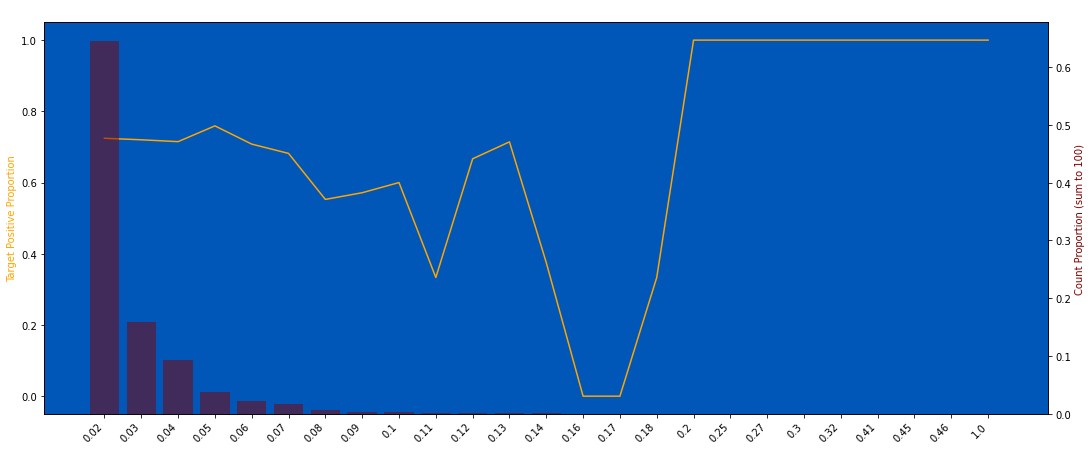

In [84]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=50)

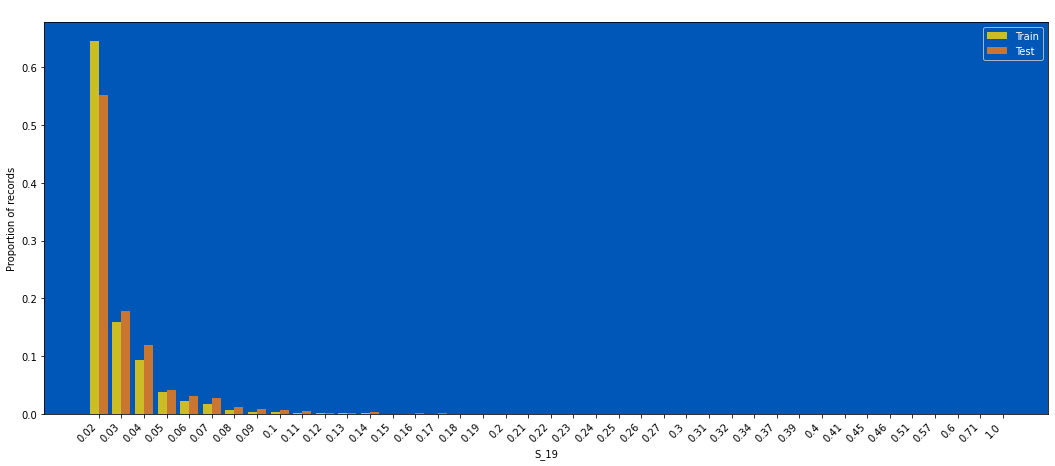

In [85]:
plot_train_test_distribution(train, test, "S_19", nunique_thr=50)

**Train Test Skew: Moderate**

### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


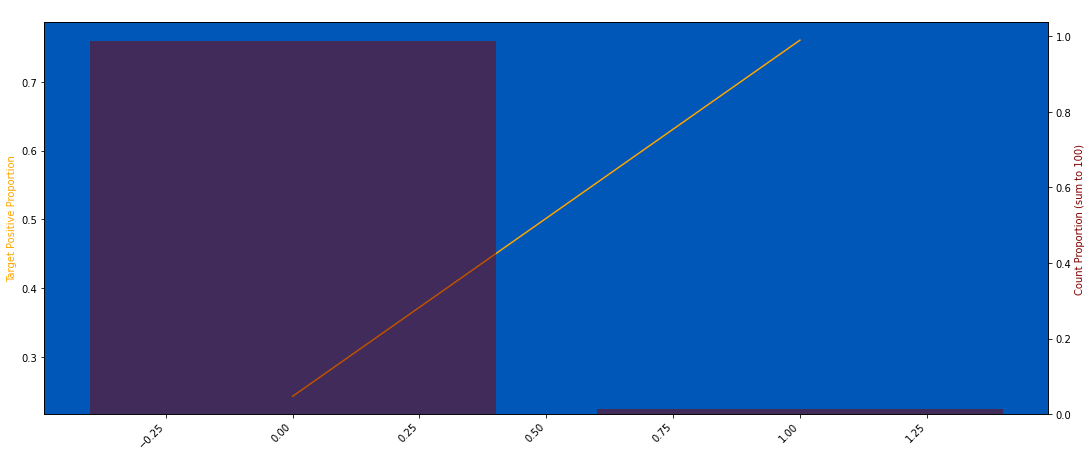

In [86]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

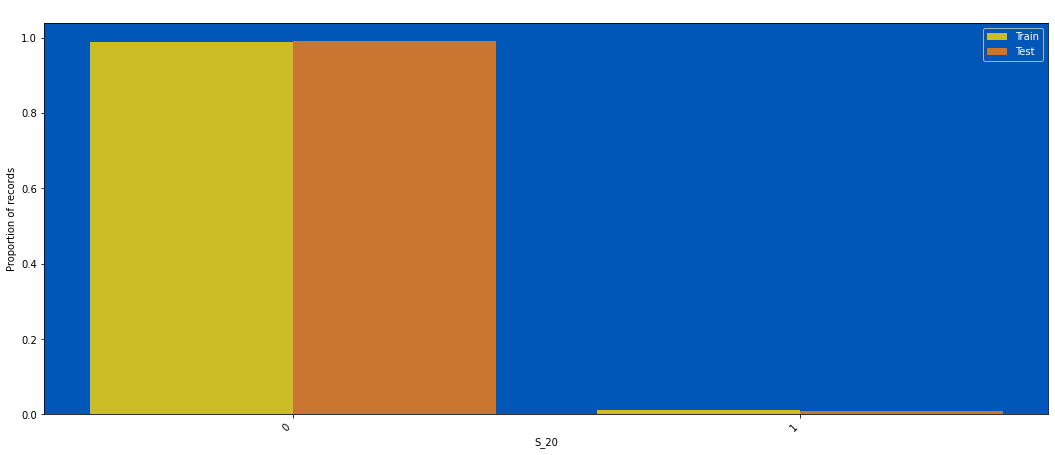

In [87]:
plot_train_test_distribution(train, test, "S_20", nunique_thr=50)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


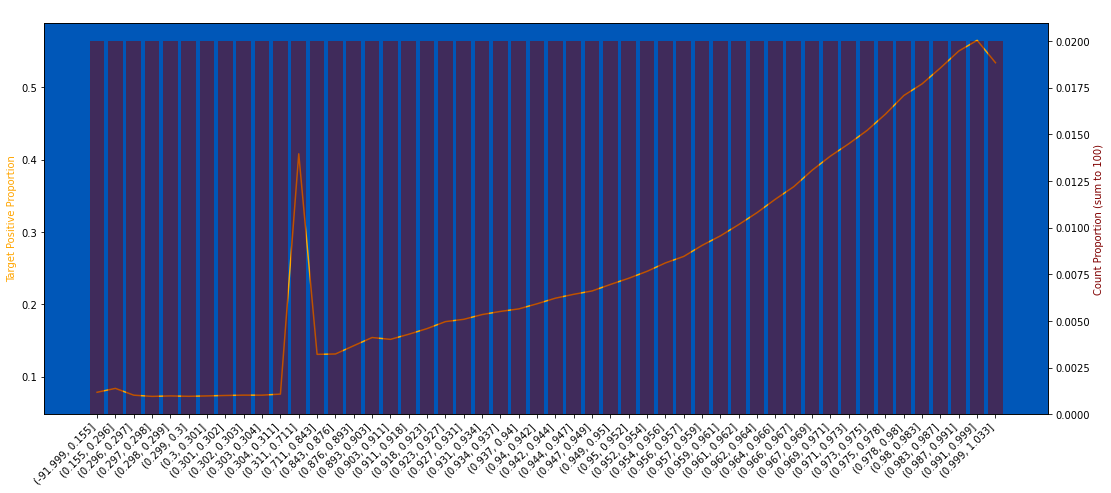

In [88]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [89]:
train["S_22"] = train["S_22"].round(2)
test["S_22"] = test["S_22"].round(2)

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


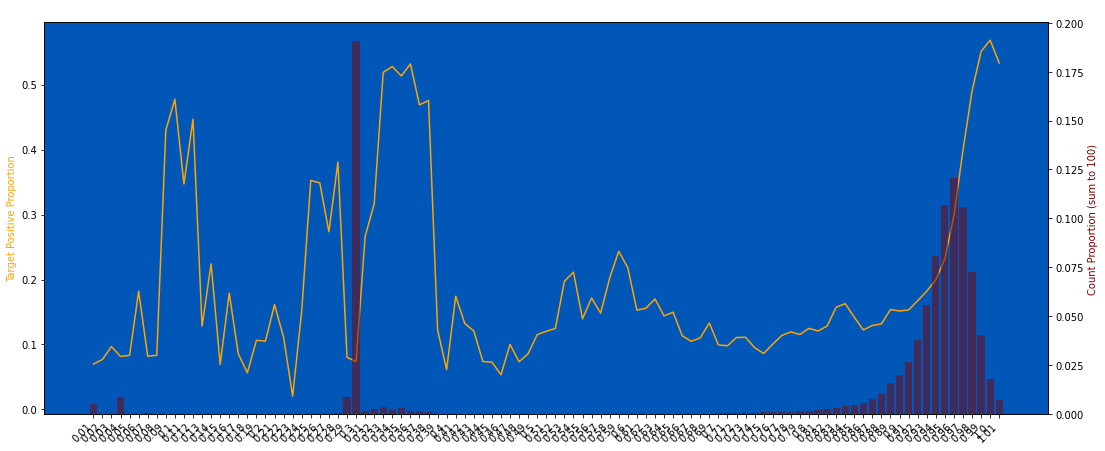

In [90]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

**Relationship is ambigious**

Bottom 1% and Top 1% are dropped from this chart


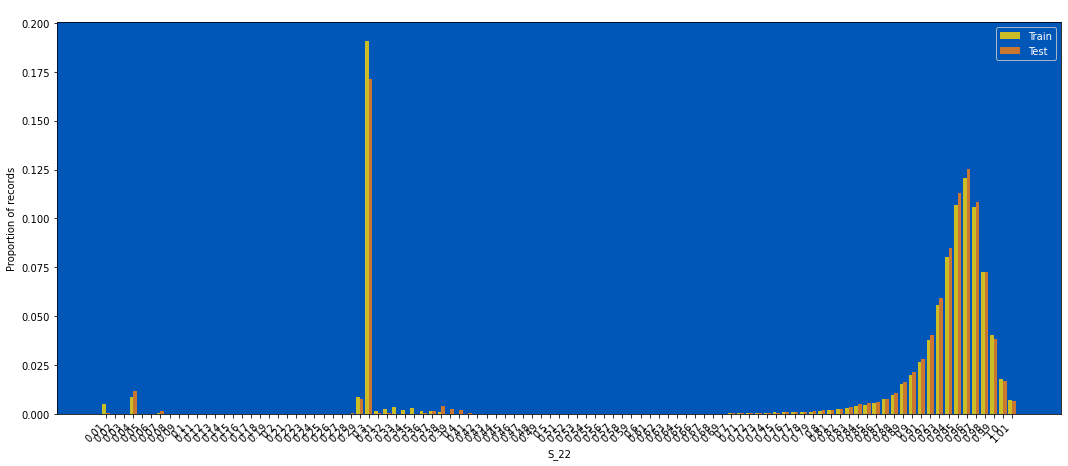

In [91]:
plot_train_test_distribution(train, test, "S_22", nunique_thr=777)

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


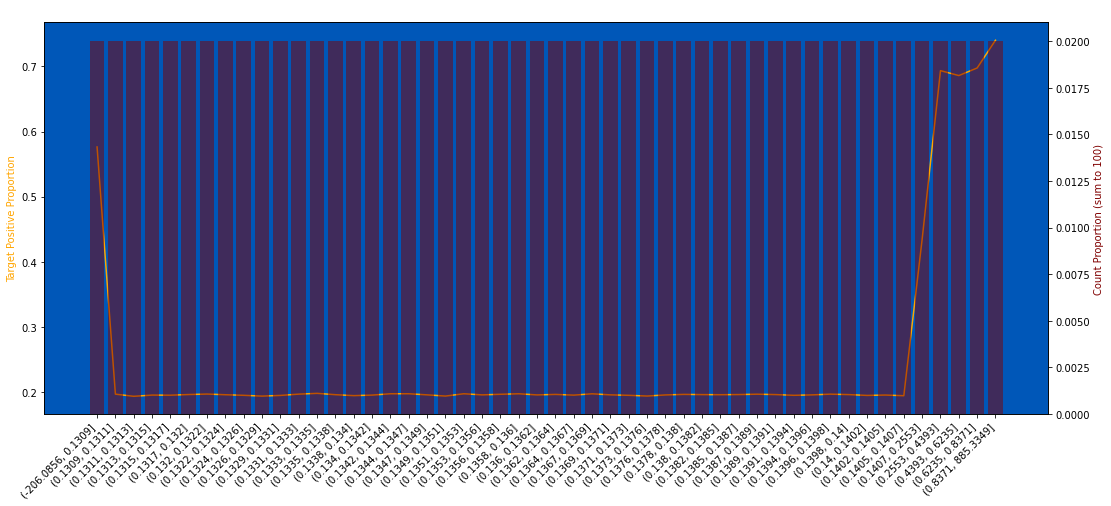

In [92]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [93]:
train["S_23"] = train["S_23"].round(2)
test["S_23"] = test["S_23"].round(2)

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


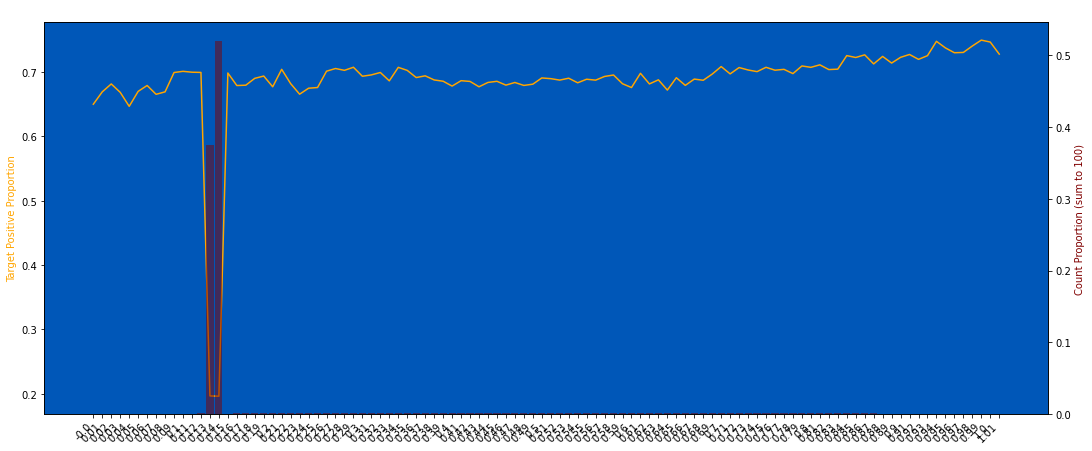

In [94]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

Bottom 1% and Top 1% are dropped from this chart


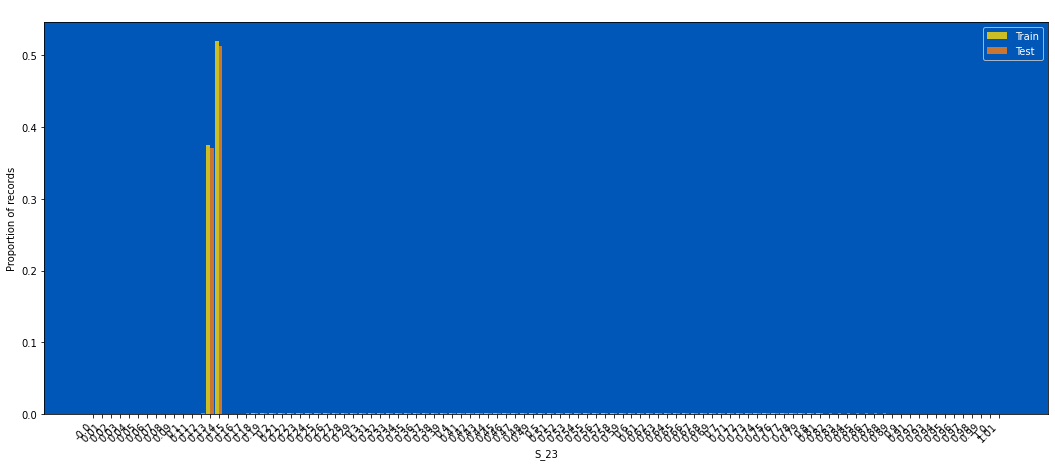

In [95]:
plot_train_test_distribution(train, test, "S_23", nunique_thr=1600)

In [96]:
train.loc[train["S_23"].between(0.129, 0.141), "S_23"] = np.nan
test.loc[test["S_23"].between(0.129, 0.141), "S_23"] = np.nan

4949043 null count, 0.895 null proportion
0.1966 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


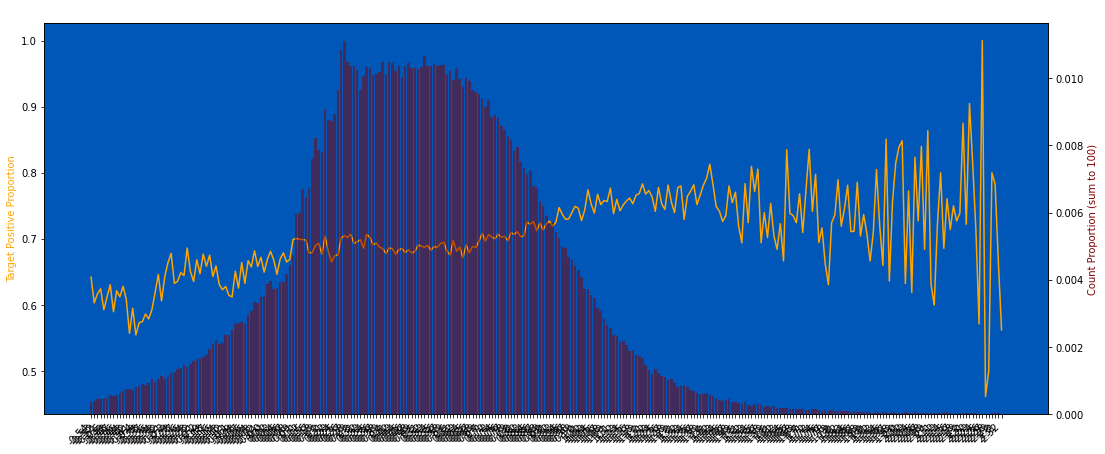

In [97]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

Bottom 1% and Top 1% are dropped from this chart


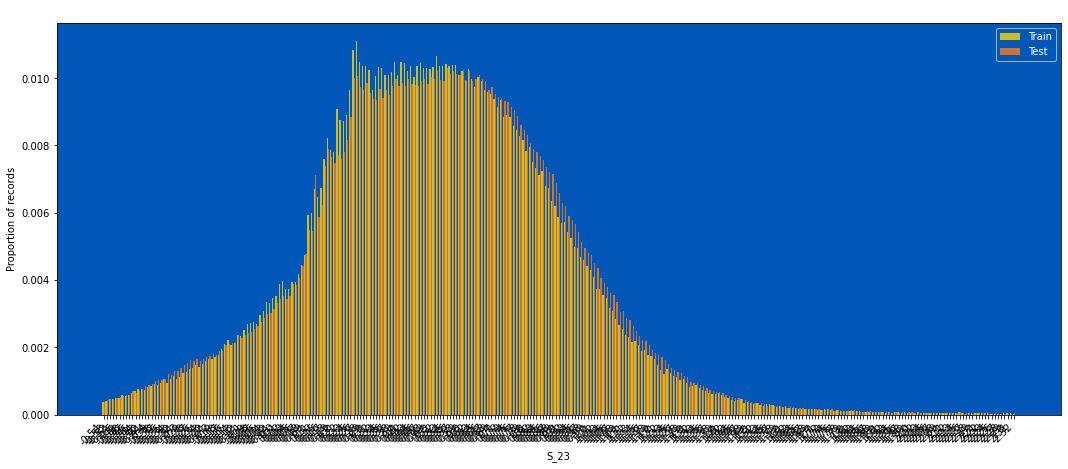

In [98]:
plot_train_test_distribution(train, test, "S_23", nunique_thr=1600)

### S_23a

In [99]:
train["S_23a"] = 0
test["S_23a"] = 0

In [100]:
train.loc[~train["S_23"].isnull(), "S_23a"] = 1
test.loc[~test["S_23"].isnull(), "S_23a"] = 1

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


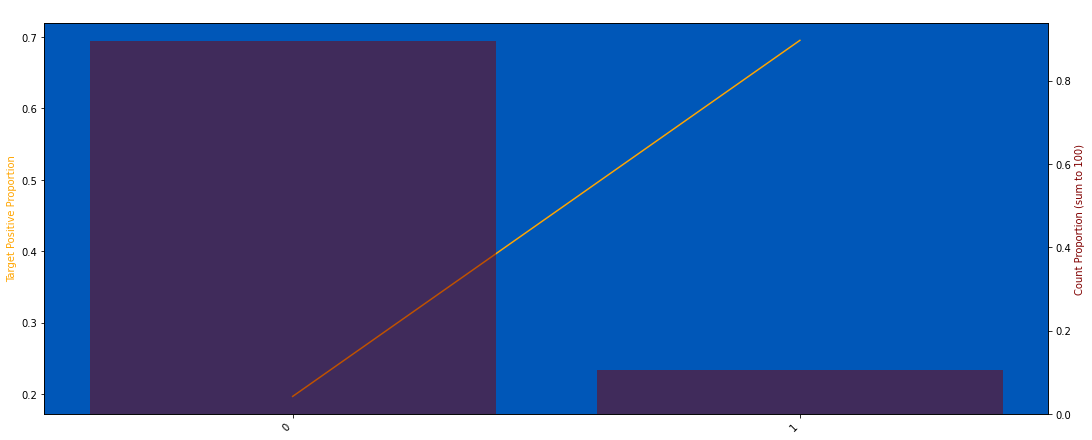

In [101]:
plot_target_check(train, "S_23a", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

Bottom 1% and Top 1% are dropped from this chart


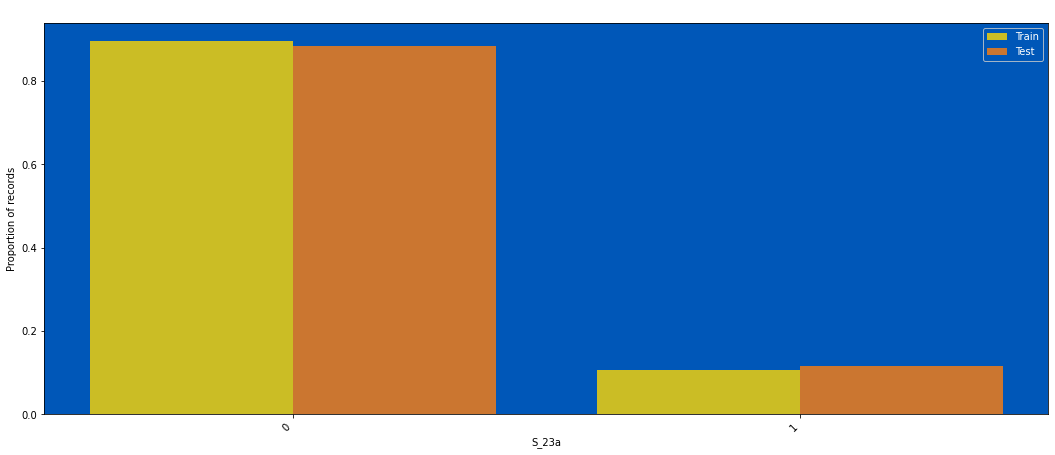

In [102]:
plot_train_test_distribution(train, test, "S_23a", nunique_thr=1600)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


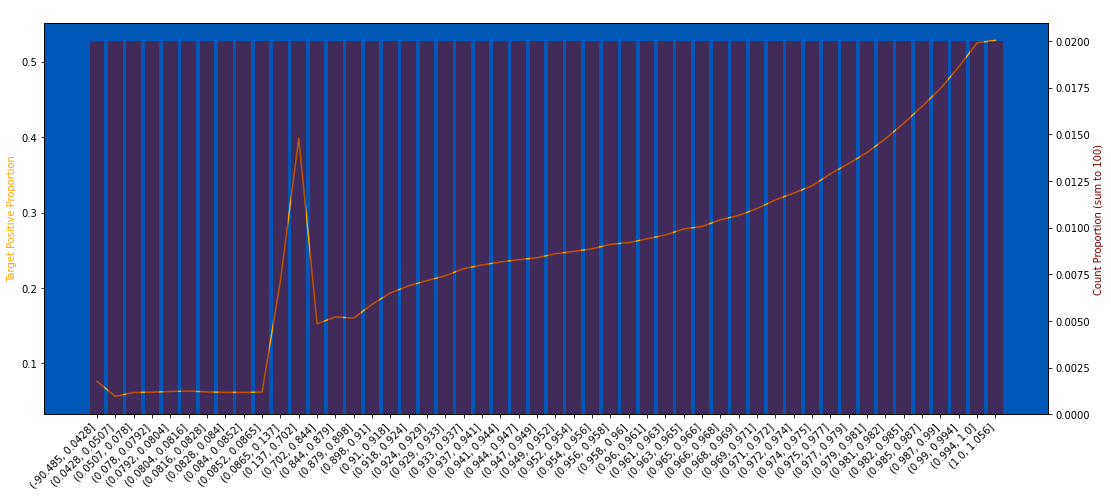

In [103]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [104]:
train["S_24"] = train["S_24"].round(2)
test["S_24"] = test["S_24"].round(2)

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


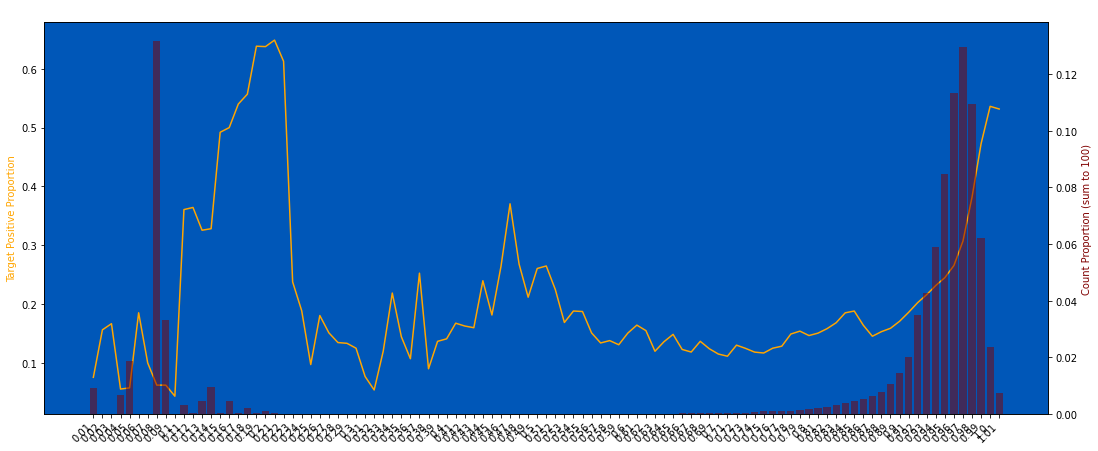

In [105]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


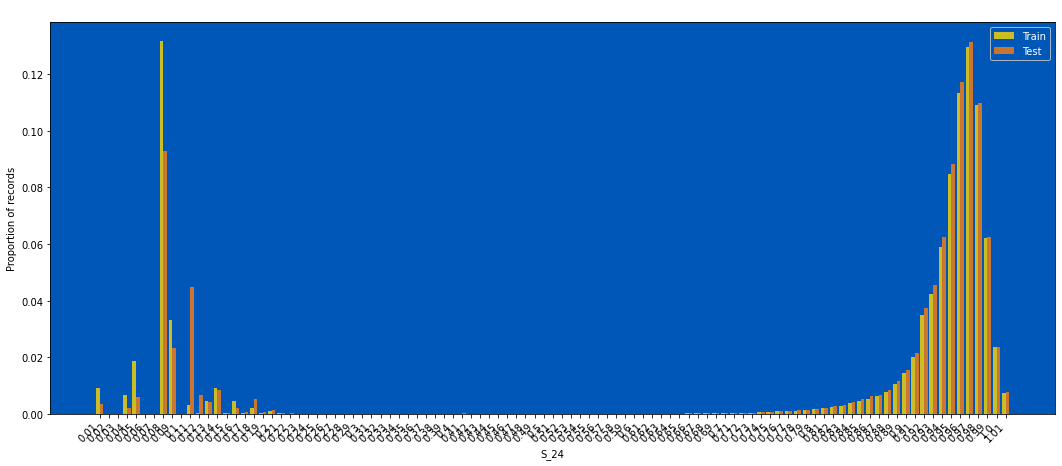

In [106]:
plot_train_test_distribution(train, test, "S_24", nunique_thr=650)

**Train Test Skew: Heavy**

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


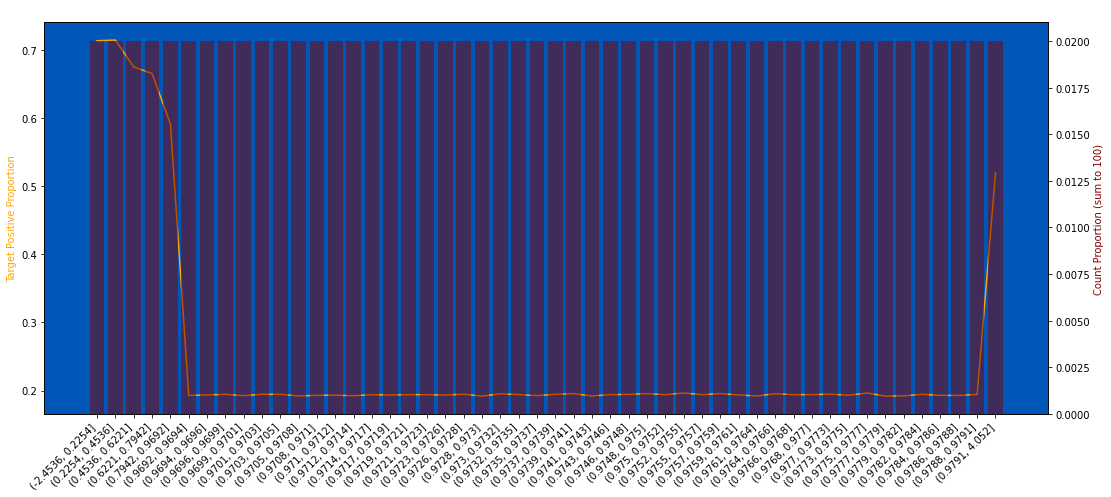

In [107]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [108]:
train["S_25"] = train["S_25"].round(2)
test["S_25"] = test["S_25"].round(2)

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


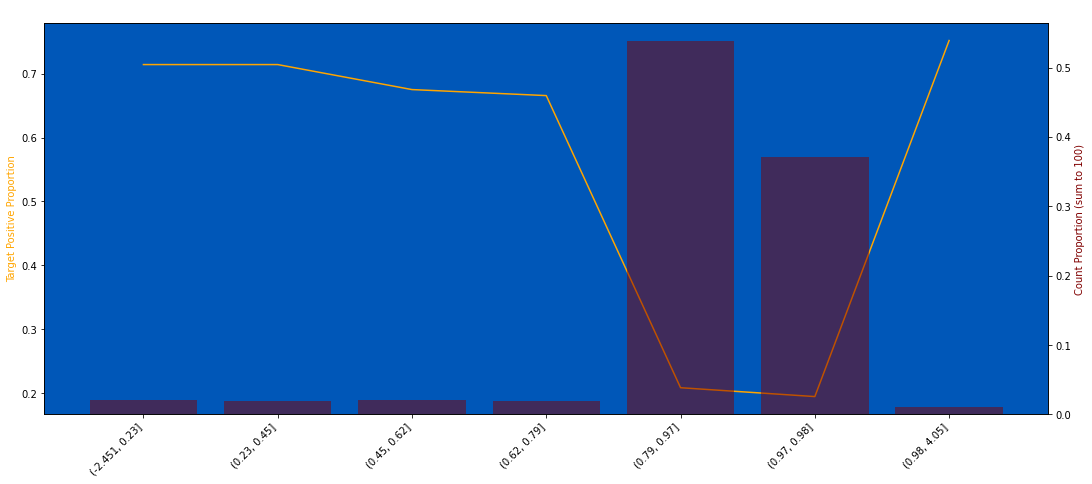

In [109]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [151]:
train.loc[train["S_25"].between(0.979, 0.991), "S_25"] = np.nan
test.loc[test["S_25"].between(0.979, 0.991), "S_25"] = np.nan

2062269 null count, 0.373 null proportion
0.1983 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


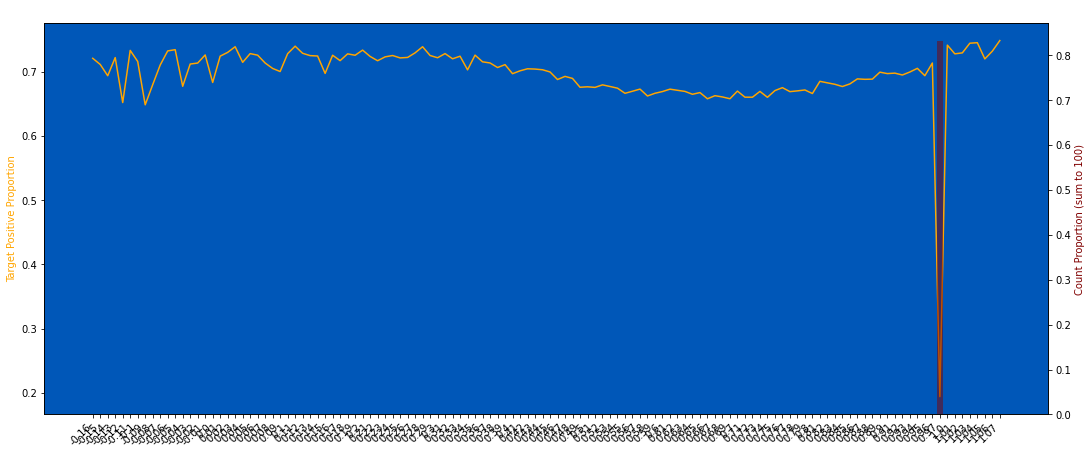

In [154]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


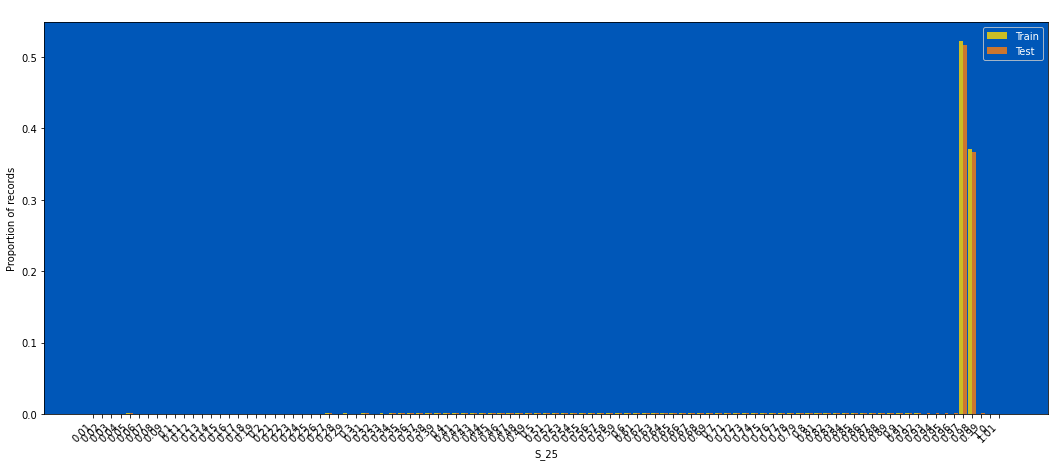

In [110]:
plot_train_test_distribution(train, test, "S_25", nunique_thr=1500)

In [111]:
train.loc[train["S_25"].between(0.97, 0.99), "S_25"] = np.nan
test.loc[test["S_25"].between(0.97, 0.99), "S_25"] = np.nan

4940675 null count, 0.893 null proportion
0.1954 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


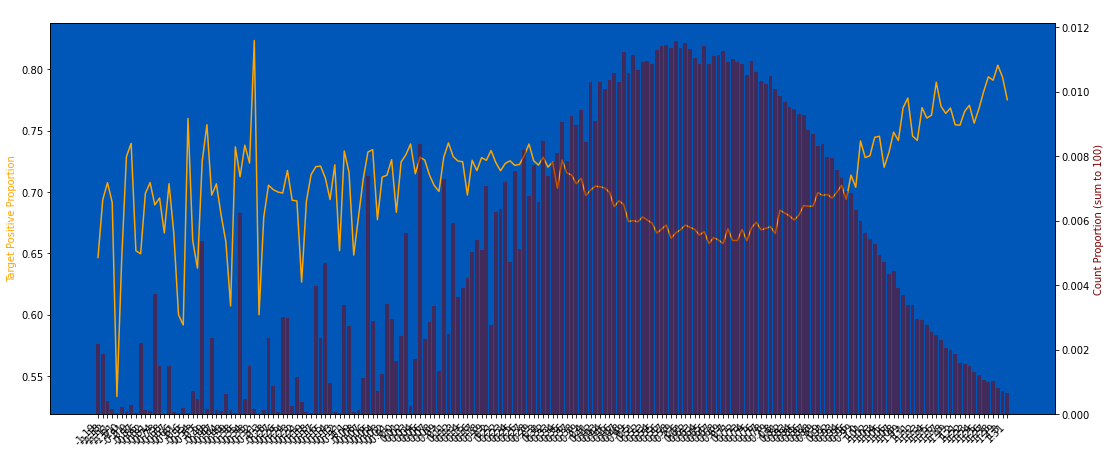

In [112]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


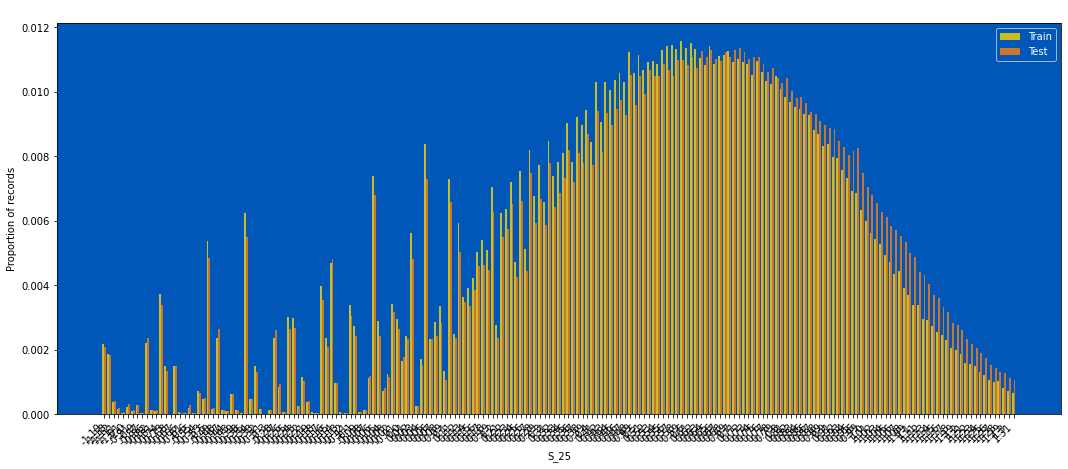

In [113]:
plot_train_test_distribution(train, test, "S_25", nunique_thr=1500)

**Train Test Skew: Moderate**

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


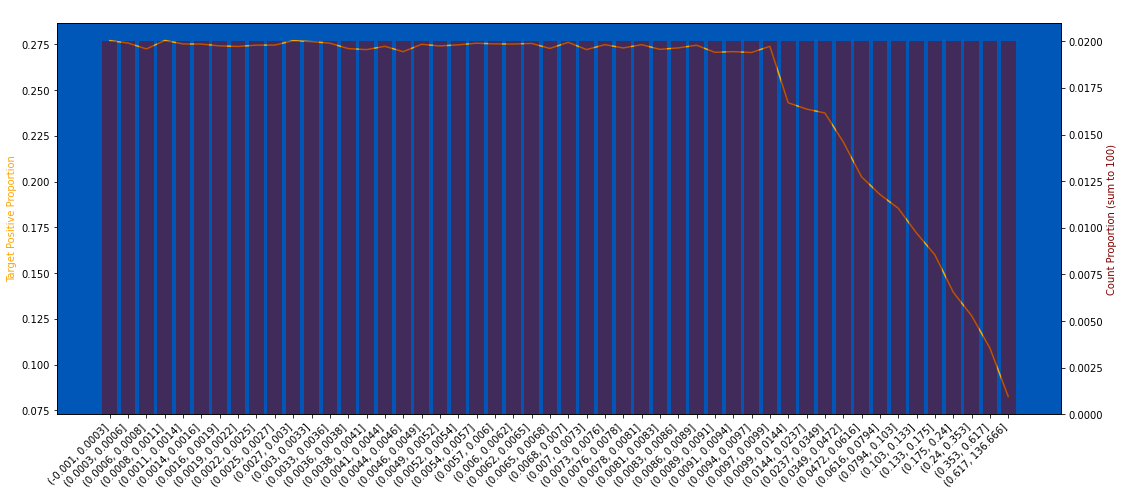

In [110]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [111]:
train["S_26"] = train["S_26"].round(2)
test["S_26"] = test["S_26"].round(2)

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


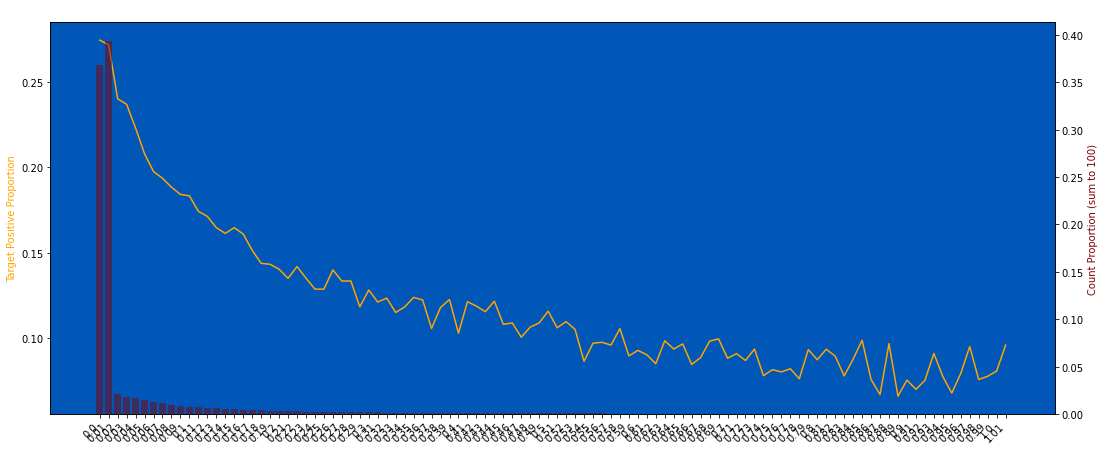

In [112]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


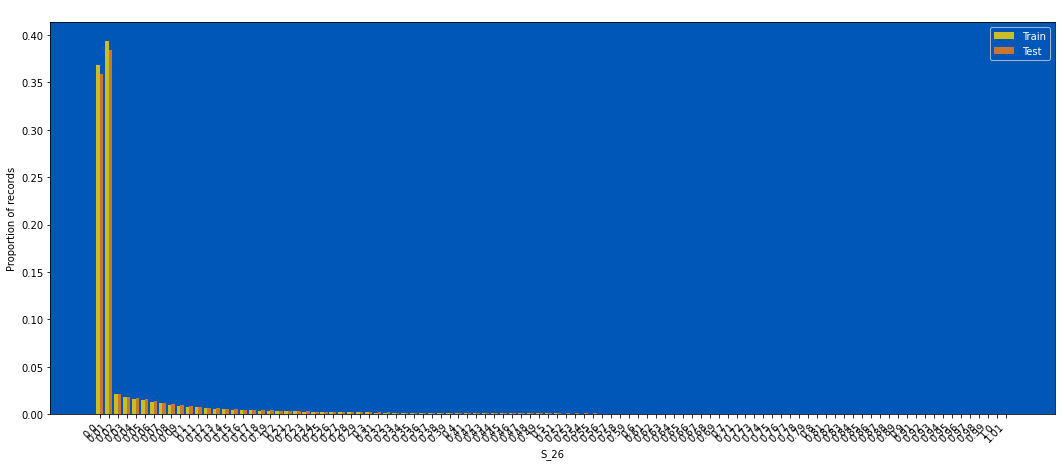

In [113]:
plot_train_test_distribution(train, test, "S_26", nunique_thr=2000)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


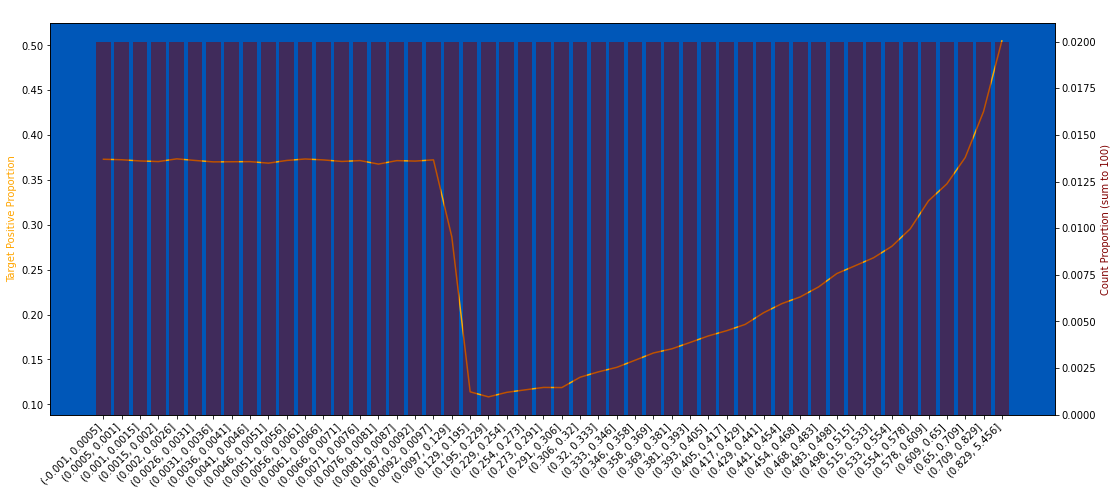

In [114]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [115]:
train["S_27"] = train["S_27"].round(2)
test["S_27"] = test["S_27"].round(2)

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


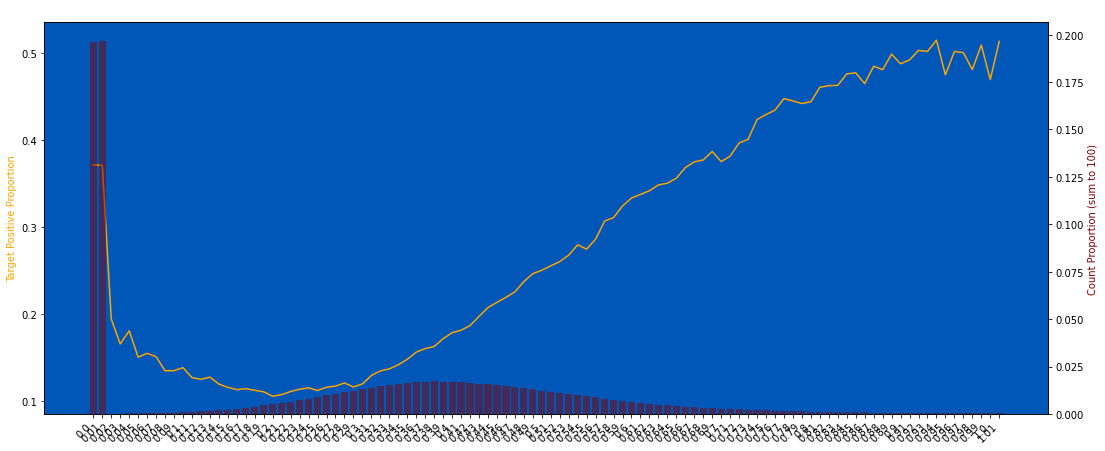

In [119]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

In [116]:
train.loc[train["S_27"].between(0, 0.02), "S_27"] = np.nan
test.loc[test["S_27"].between(0, 0.02), "S_27"] = np.nan

3024683 null count, 0.547 null proportion
0.2778 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


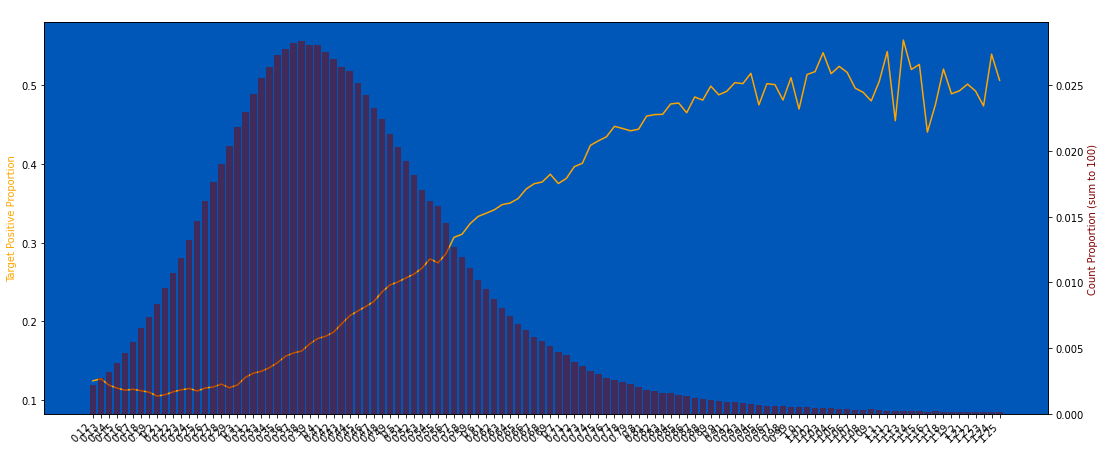

In [117]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


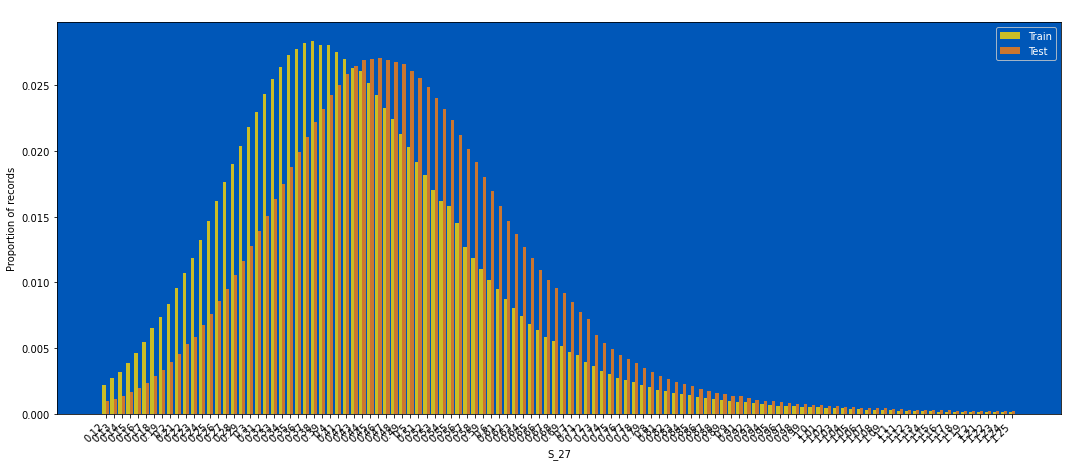

In [118]:
plot_train_test_distribution(train, test, "S_27", nunique_thr=1500)

**Train Test Skew: Heavy**

### S_27a

In [119]:
train["S_27a"] = 0
test["S_27a"] = 0

In [120]:
train.loc[~train["S_27"].isnull(), "S_27a"] = 1
test.loc[~test["S_27"].isnull(), "S_27a"] = 1

0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


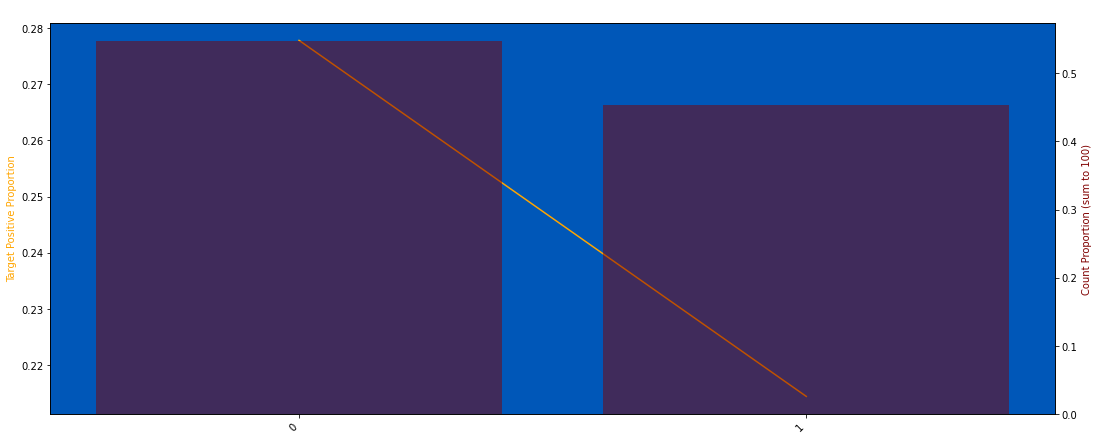

In [126]:
plot_target_check(train, "S_27a", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=5000)

Bottom 1% and Top 1% are dropped from this chart


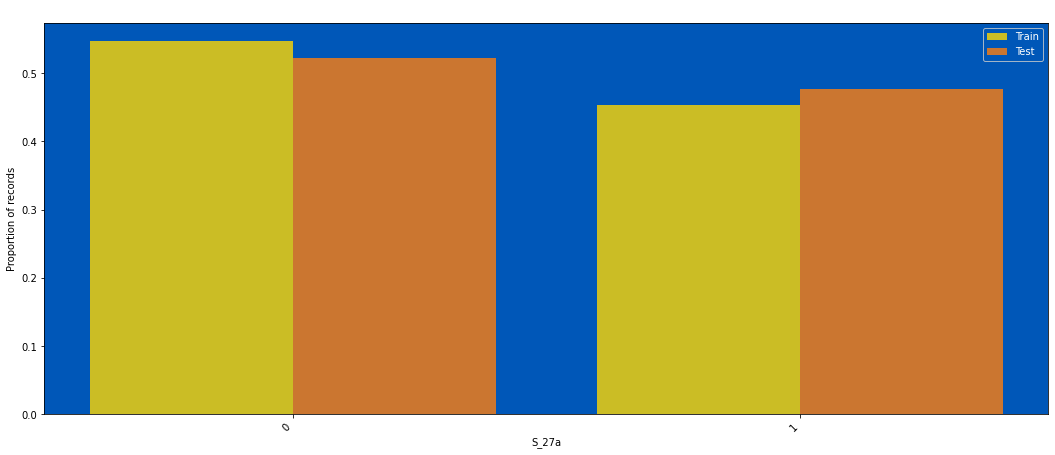

In [122]:
plot_train_test_distribution(train, test, "S_27a", nunique_thr=1600)

### Column checking

In [126]:
from tqdm import tqdm

In [127]:
all_columns = get_cols(train, ["P_", "S_"])

In [128]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -1, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-1, -999)
    neg1_series = test.loc[test[d] == -1, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-1, -999)

  7%|█████████▎                                                                                                                    | 2/27 [00:01<00:13,  1.89it/s]

Train P_3 2


 22%|████████████████████████████                                                                                                  | 6/27 [00:03<00:08,  2.39it/s]

Test P_3 13


 70%|███████████████████████████████████████████████████████████████████████████████████████▉                                     | 19/27 [00:03<00:00, 11.66it/s]

Train S_22 4
Test S_22 5
Train S_23 21


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 21/27 [00:07<00:03,  1.88it/s]

Test S_23 46
Train S_24 3
Test S_24 11
Train S_25 138


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 24/27 [00:10<00:01,  1.53it/s]

Test S_25 435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.57it/s]


In [129]:
for d in tqdm(all_columns):
    train[d] = train[d].fillna(-127)
    test[d] = test[d].fillna(-127)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:24<00:00,  1.10it/s]


In [130]:
for d in tqdm(all_columns):
    neg1_series = train.loc[train[d] == -999, d]
    if len(neg1_series) > 0:
        print("Train", d, len(neg1_series))
        train[d] = train[d].replace(-999, -1)
    neg1_series = test.loc[test[d] == -999, d]
    if len(neg1_series) > 0:
        print("Test", d, len(neg1_series))
        test[d] = test[d].replace(-999, -1)

 63%|██████████████████████████████████████████████████████████████████████████████▋                                              | 17/27 [00:00<00:00, 28.68it/s]

Train P_3 2
Test P_3 13
Train S_22 4
Test S_22 5
Train S_23 21
Test S_23 46
Train S_24 3
Test S_24 11
Train S_25 138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.21it/s]

Test S_25 435


In [131]:
d_col_nunique = train[all_columns].nunique()

In [132]:
less_unique_d_cols = d_col_nunique[d_col_nunique < 64].index.tolist()

In [133]:
for d in less_unique_d_cols:
    print(d, ":", train[d].dtype, "\n", sorted(train[d].unique().tolist()), "\n")

S_6 : int8 
 [0, 1] 

S_8 : float64 
 [-127.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0] 

S_13 : float64 
 [-127.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0] 

S_15 : int8 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56] 

P_4 : float32 
 [-127.0, 0.7799999713897705, 0.7900000214576721, 0.800000011920929, 0.8100000023841858, 0.8199999928474426, 0.8299999833106995, 0.8399999737739563, 0.8500000238418579, 0.8600000143051147, 0.8700000047683716, 0.8799999952316284, 0.8899999856948853, 0.8999999761581421, 0.9100000262260437, 0.9200000166893005, 0.9300000071525574, 0.9399999976158142, 0.949999988079071, 0.9599999785423279, 0.9700000286102295, 0.9800000190734863, 0.990

In [134]:
# for col in tqdm(less_unique_d_cols):
#     train[col] = integerize(train[col])
#     test[col] = integerize(test[col])

In [135]:
train = train.drop(columns="temp", errors="ignore")
test = test.drop(columns="temp", errors="ignore")

In [136]:
train.shape, test.shape

((5531451, 193), (11363762, 192))

In [137]:
%%time
train.to_parquet(f"{RAW_TRAIN_PARQUET_PATH}/train_ps.parquet")
test.to_parquet(f"{RAW_TEST_PARQUET_PATH}/test_ps.parquet")

CPU times: user 1min 6s, sys: 43.1 s, total: 1min 49s
Wall time: 1min 24s


In [138]:
END = time.time()

In [139]:
print(f"{END - START:.2f} seconds elapsed")

974.85 seconds elapsed


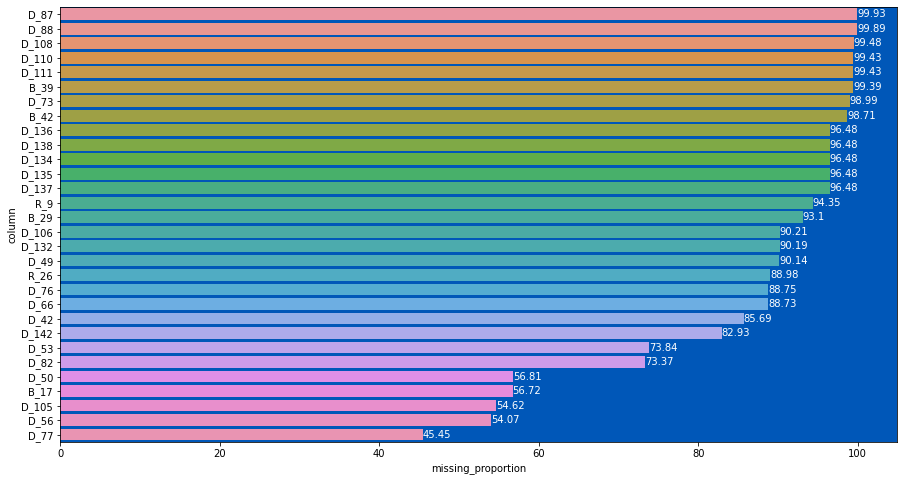

In [140]:
missing_df = plot_missing_proportion_barchart(train)

### Check Column

In [141]:
(train["D_106"].round(1) - train["D_106"]).fillna(0).sum()

0.0